In [2]:
def check_results_in_db(conn, descriptor, model_name, seed):
    query = """
    SELECT y_true, y_pred, molregno FROM cs_mdfps_schema.model_descriptor_results 
    WHERE descriptor=%s AND model=%s AND seed=%s
    """
    cur = conn.cursor()
    cur.execute(query, (descriptor, model_name, seed))
    results = cur.fetchone()
    cur.close()
    return results

import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=lebanon")
descriptor = 'RDKit_PhysChem'
models_to_evaluate = ['MultilinearRegression', 'RidgeRegression', 'Lasso', 'PLS', 'RandomForest', 'XGBoost', 'NeuralNetwork']
predictions_lol, y_list_lol, molregno_list_lol = [], [], []
for model_name in models_to_evaluate:
    predictions, y_list, molregno_list = [], [], []
    for i in range(10):
        result = check_results_in_db(conn, descriptor, model_name, i)
        if result:
            y_true, y_pred, molregno = result
            predictions.append(y_pred)
            y_list.append(y_true)
            molregno_list.append(molregno)
    predictions_lol.append(predictions)
    y_list_lol.append(y_list)
    molregno_list_lol.append(molregno_list)
print(len(predictions), len(y_list), len(molregno_list))
print(len(predictions_lol), len(y_list_lol), len(molregno_list_lol))

10 10 10
7 7 7


/localhome/cschiebroek/.conda/envs/molecular-descriptors/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/molecular-descriptors/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/molecular-descriptors/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/localhome/cschiebroek/.conda/envs/molecular-descriptors/lib/python3.9/site-packages/

KeyboardInterrupt: 

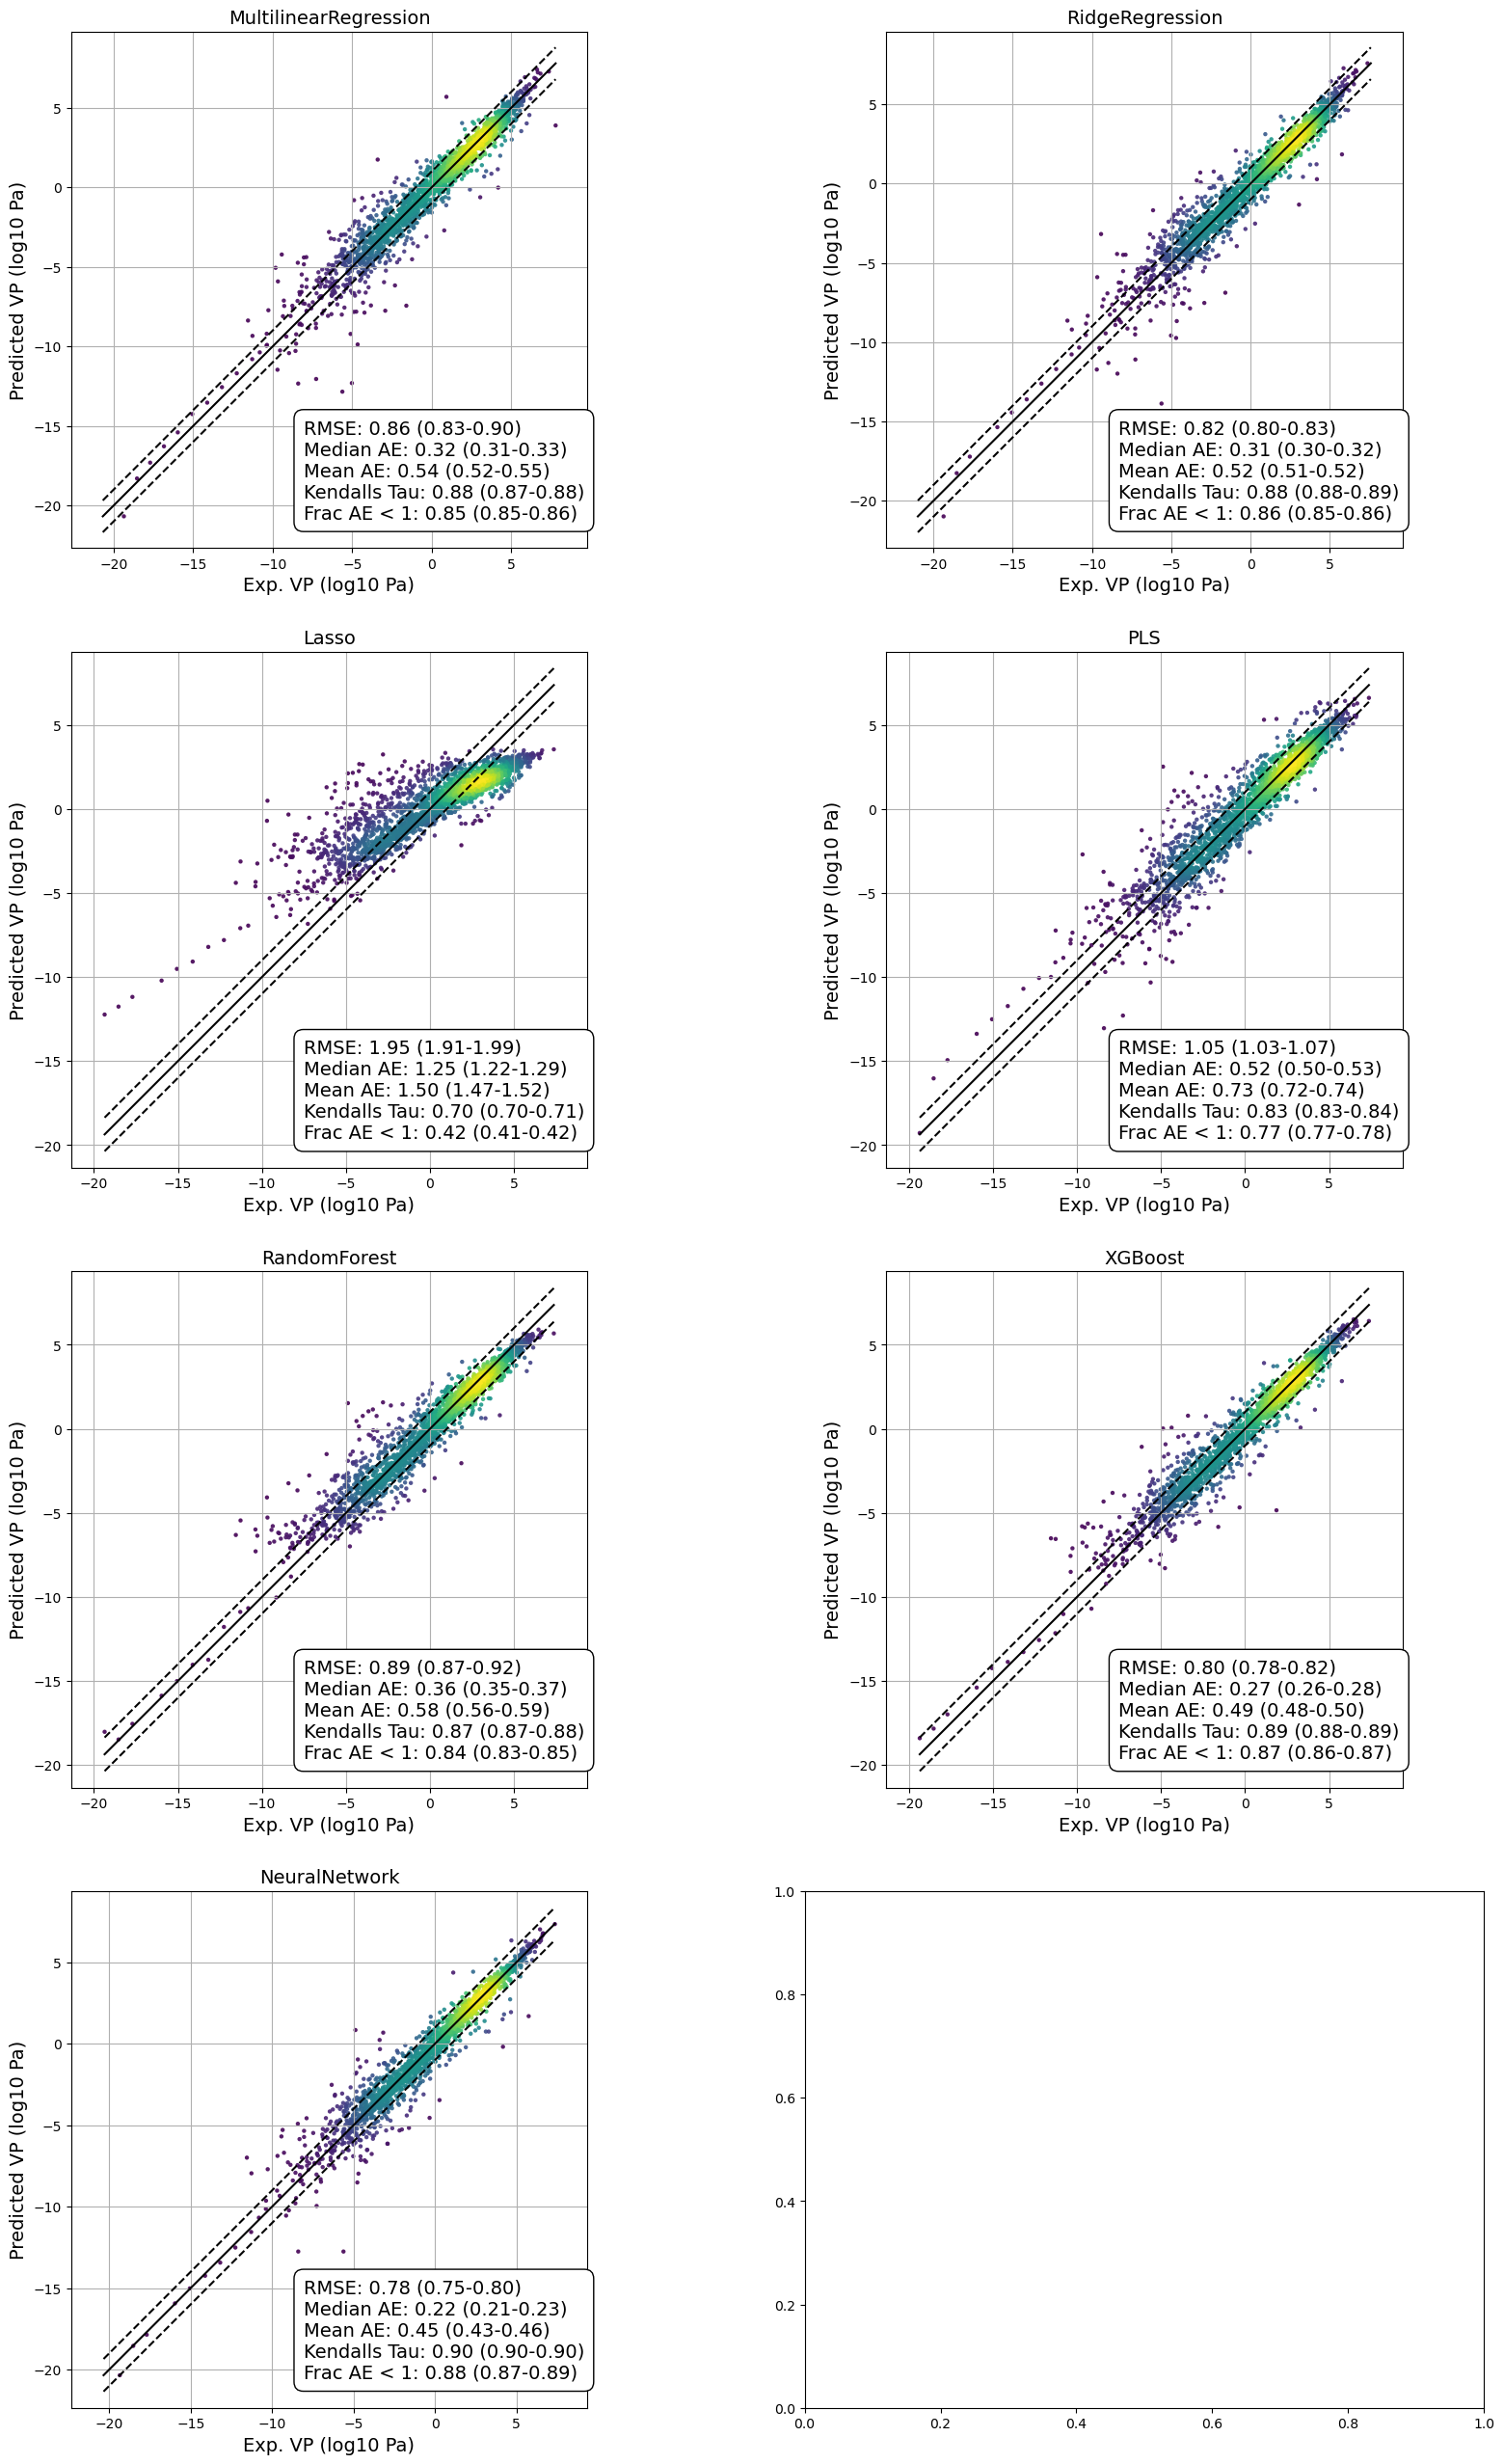

In [3]:
from utils.visualization import density_plots


density_plots(reals_list=y_list_lol, predictions_list=predictions_lol, molregnos_list=molregno_list_lol,
                print_stats=True, bounds=None, title=models_to_evaluate,
                name="Simple", dims=(4,2), thresholds=1)

/tmp/ipykernel_1787826/1522105261.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1522105261.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1522105261.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1522105261.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1522105261.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1522105261.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1522105261.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `err

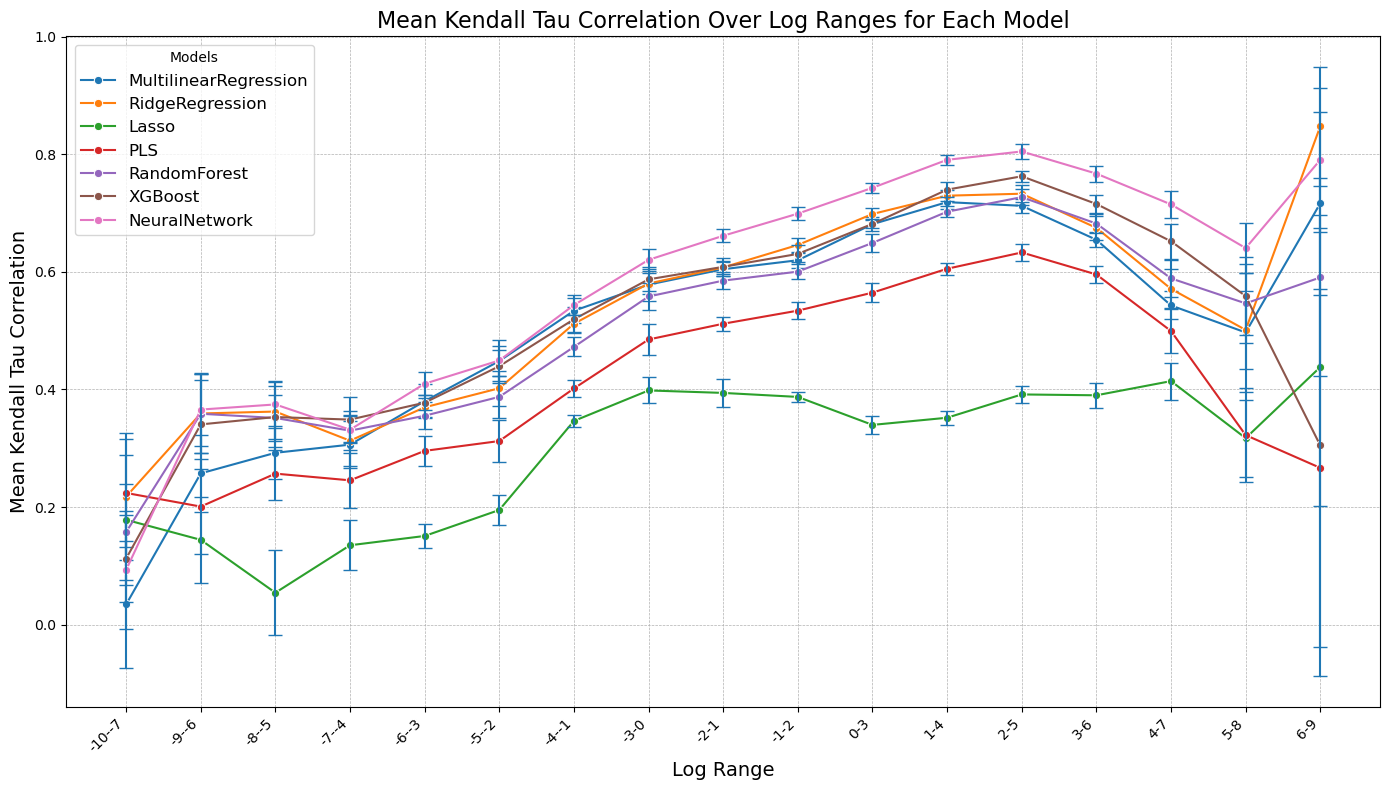

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Define the log range and step size
log_ranges = [(i, i + 3) for i in range(-10, 7)]

# Initialize a dictionary to store Kendall tau correlations
kendall_results = {f'Model {i+1}': [] for i in range(len(y_list_lol))}

# Calculate Kendall tau for each model and split over the defined log ranges
for model_idx, (ys, preds) in enumerate(zip(y_list_lol, predictions_lol)):
    for log_min, log_max in log_ranges:
        split_kendalls = []
        for split_idx in range(len(ys)):
            # Filter data within the current log range
            mask = (np.array(ys[split_idx]) >= log_min) & (np.array(ys[split_idx]) < log_max)
            if np.sum(mask) > 1:  # Check if there are enough points to calculate correlation
                tau, _ = kendalltau(np.array(ys[split_idx])[mask], np.array(preds[split_idx])[mask])
                split_kendalls.append(tau)
            else:
                split_kendalls.append(np.nan)  # Not enough data points

        # Store the mean and confidence interval for each range
        mean_tau = np.nanmean(split_kendalls)
        ci_tau = 1.645 * np.nanstd(split_kendalls) / np.sqrt(len(split_kendalls))  # 90% CI
        kendall_results[f'Model {model_idx+1}'].append((mean_tau, ci_tau))

# Prepare data for plotting
plot_data = []
for model_name, correlations in kendall_results.items():
    for (log_min, log_max), (mean_tau, ci_tau) in zip(log_ranges, correlations):
        plot_data.append({
            'Model': model_name,
            'Log Range': f'{log_min}-{log_max}',
            'Mean Kendall Tau': mean_tau,
            'CI (90%)': ci_tau
        })

plot_df = pd.DataFrame(plot_data)
#rename models to models_to_evaluate
plot_df['Model'] = plot_df['Model'].replace({f'Model {i+1}': models_to_evaluate[i] for i in range(len(models_to_evaluate))})

# Plot using seaborn
plt.figure(figsize=(14, 8))
for model in plot_df['Model'].unique():
    model_data = plot_df[plot_df['Model'] == model]
    sns.lineplot(
        x=model_data['Log Range'],
        y=model_data['Mean Kendall Tau'],
        label=model,
        marker='o',
        ci=None
    )
    # Plot error bars manually for 90% CI
    plt.errorbar(
        x=model_data['Log Range'],
        y=model_data['Mean Kendall Tau'],
        yerr=model_data['CI (90%)'],
        fmt='none',
        capsize=5
    )

    

plt.xlabel('Log Range', fontsize=14)
plt.ylabel('Mean Kendall Tau Correlation', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.title('Mean Kendall Tau Correlation Over Log Ranges for Each Model', fontsize=16)
plt.legend(title='Models', fontsize=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
model_data.head()

,Model,Log Range,Mean Kendall Tau,CI (90%)
102,NeuralNetwork,-10--7,0.093069,0.099579
103,NeuralNetwork,-9--6,0.365830,0.061608
104,NeuralNetwork,-8--5,0.374548,0.039224
105,NeuralNetwork,-7--4,0.331616,0.022426
106,NeuralNetwork,-6--3,0.409787,0.019890


In [ ]:
df_correlation_exp = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/group_talk_19_09_2024/correlations_opera_naef.csv')
df_correlation_exp.head()

,VP OPERA range,VP OPERA range + 3,Pearson,Spearman,Kendall
0,-10,-7,0.354400,0.405007,0.268908
1,-9,-6,0.322170,0.331883,0.254545
2,-8,-5,0.555273,0.569662,0.442545
3,-7,-4,0.281960,0.303867,0.226512
4,-6,-3,0.511906,0.547320,0.371576


In [ ]:
#make new column Log Range, formatted as VP OPERA range	- VP OPERA range + 3	
df_correlation_exp['Log Range'] = df_correlation_exp['VP OPERA range'].astype(str) + '-' + (df_correlation_exp['VP OPERA range'] + 3).astype(str)
df_correlation_exp['Model'] = 'Experimental'
df_correlation_exp.rename(columns={'Kendall': 'Mean Kendall Tau'}, inplace=True)
df_correlation_exp.head()

,VP OPERA range,VP OPERA range + 3,Pearson,Spearman,Mean Kendall Tau,Log Range,Model
0,-10,-7,0.354400,0.405007,0.268908,-10--7,Experimental
1,-9,-6,0.322170,0.331883,0.254545,-9--6,Experimental
2,-8,-5,0.555273,0.569662,0.442545,-8--5,Experimental
3,-7,-4,0.281960,0.303867,0.226512,-7--4,Experimental
4,-6,-3,0.511906,0.547320,0.371576,-6--3,Experimental


8


/tmp/ipykernel_1787826/1782854275.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1782854275.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1782854275.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1782854275.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1782854275.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1782854275.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/1782854275.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `err

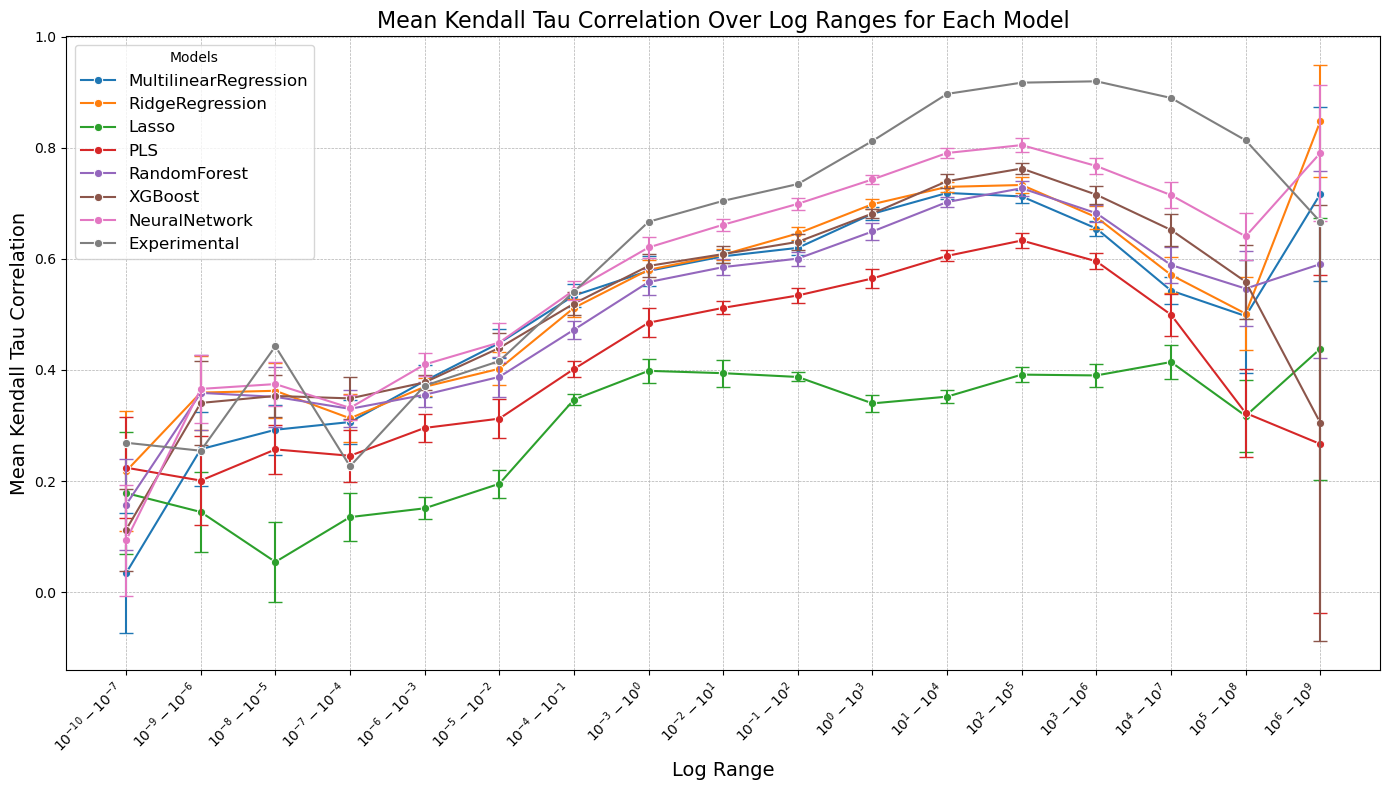

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Define the log range and step size
log_ranges = [(i, i + 3) for i in range(-10, 7)]

# Initialize a dictionary to store Kendall tau correlations
kendall_results = {f'Model {i+1}': [] for i in range(len(y_list_lol))}

# Calculate Kendall tau for each model and split over the defined log ranges
for model_idx, (ys, preds) in enumerate(zip(y_list_lol, predictions_lol)):
    for log_min, log_max in log_ranges:
        split_kendalls = []
        for split_idx in range(len(ys)):
            # Filter data within the current log range
            mask = (np.array(ys[split_idx]) >= log_min) & (np.array(ys[split_idx]) < log_max)
            if np.sum(mask) > 1:  # Check if there are enough points to calculate correlation
                tau, _ = kendalltau(np.array(ys[split_idx])[mask], np.array(preds[split_idx])[mask])
                split_kendalls.append(tau)
            else:
                split_kendalls.append(np.nan)  # Not enough data points

        # Store the mean and confidence interval for each range
        mean_tau = np.nanmean(split_kendalls)
        ci_tau = 1.645 * np.nanstd(split_kendalls) / np.sqrt(len(split_kendalls))  # 90% CI
        kendall_results[f'Model {model_idx+1}'].append((mean_tau, ci_tau))

# Prepare data for plotting
plot_data = []
for model_name, correlations in kendall_results.items():
    for (log_min, log_max), (mean_tau, ci_tau) in zip(log_ranges, correlations):
        plot_data.append({
            'Model': model_name,
            'Log Range': f'{log_min}-{log_max}',
            'Mean Kendall Tau': mean_tau,
            'CI (90%)': ci_tau
        })

plot_df = pd.DataFrame(plot_data)
#rename models to models_to_evaluate
plot_df['Model'] = plot_df['Model'].replace({f'Model {i+1}': models_to_evaluate[i] for i in range(len(models_to_evaluate))})
colors = sns.color_palette('tab10', n_colors=len(plot_df['Model'].unique()) + 1 )
print(len(colors))
# Plot using seaborn
plt.figure(figsize=(14, 8))
for i,model in enumerate(plot_df['Model'].unique()):
    model_data = plot_df[plot_df['Model'] == model]
    sns.lineplot(
        x=model_data['Log Range'],
        y=model_data['Mean Kendall Tau'],
        label=model,
        marker='o',
        ci=None,
        color=colors[i]
    )
    # Plot error bars manually for 90% CI
    plt.errorbar(
        x=model_data['Log Range'],
        y=model_data['Mean Kendall Tau'],
        yerr=model_data['CI (90%)'],
        fmt='none',
        capsize=5,
        color=colors[i]
    )
model_data = df_correlation_exp['Model'] == 'Experimental'
sns.lineplot(
    x=df_correlation_exp['Log Range'],
    y=df_correlation_exp['Mean Kendall Tau'],
    label='Experimental',
    marker='o',
    ci=None,
    color=colors[-1]
)

plt.xlabel('Log Range', fontsize=14)
plt.ylabel('Mean Kendall Tau Correlation', fontsize=14)
plt.xticks(rotation=45, ha='right')
# #fix xticklabels; change to 10^x - 10^(x+3)
# xticklabels.append(f'$10^{{{i}}}$ - $10^{{{i + 3}}}$')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])
plt.title('Mean Kendall Tau Correlation Over Log Ranges for Each Model', fontsize=16)
plt.legend(title='Models', fontsize=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
#keep only MultilinearRegression and NeuralNetwork
models_to_evaluate = ['MultilinearRegression', 'NeuralNetwork']
plot_df_minimum = plot_df[plot_df['Model'].isin(models_to_evaluate)]
plot_df_minimum

,Model,Log Range,Mean Kendall Tau,CI (90%)
0,MultilinearRegression,-10--7,0.034413,0.107370
1,MultilinearRegression,-9--6,0.257354,0.066054
2,MultilinearRegression,-8--5,0.292307,0.044883
3,MultilinearRegression,-7--4,0.306188,0.040200
4,MultilinearRegression,-6--3,0.380034,0.028865
5,MultilinearRegression,-5--2,0.448370,0.026180
6,MultilinearRegression,-4--1,0.533828,0.021457
7,MultilinearRegression,-3-0,0.578284,0.027244
8,MultilinearRegression,-2-1,0.604486,0.011858
9,MultilinearRegression,-1-2,0.619733,0.012477


/tmp/ipykernel_1787826/2814467473.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/2814467473.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1787826/2814467473.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


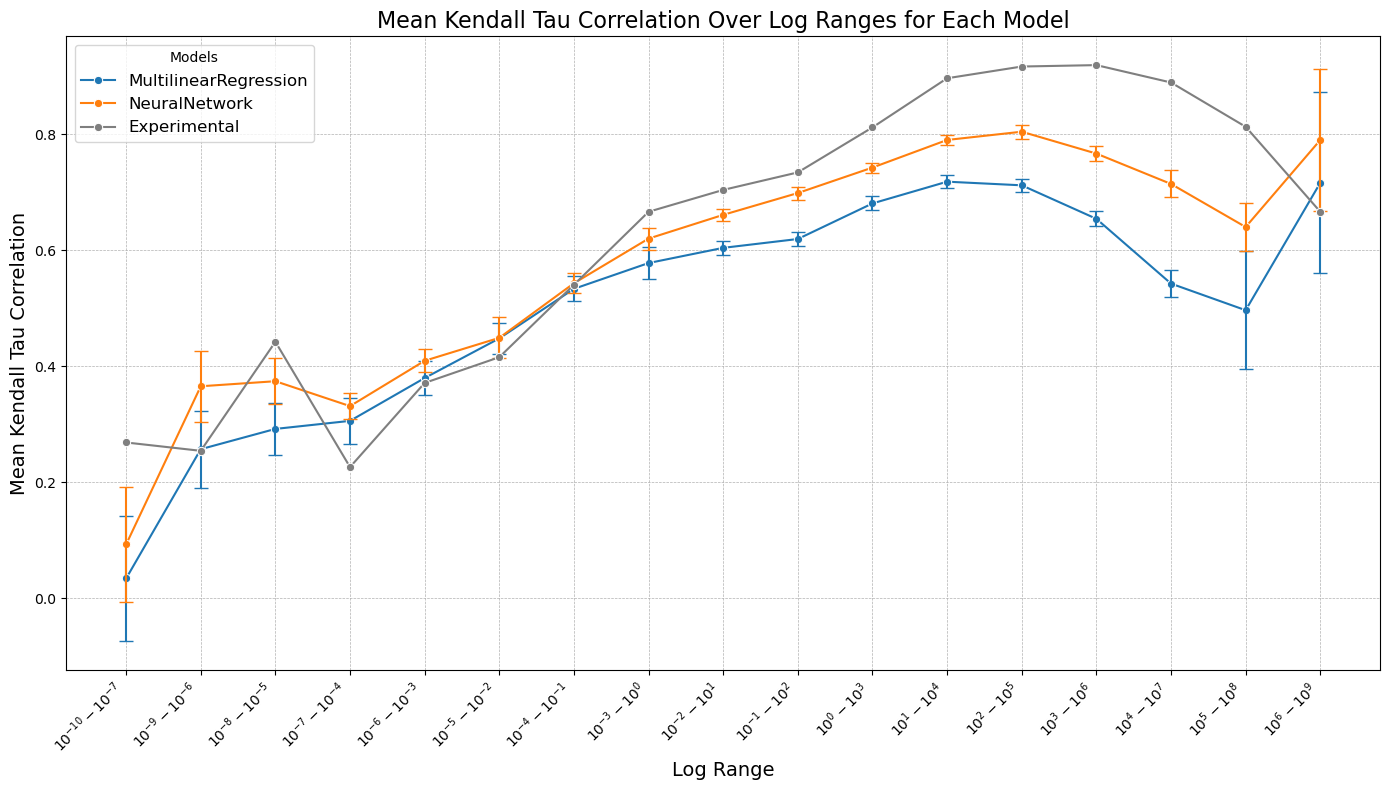

In [ ]:
plt.figure(figsize=(14, 8))
for i,model in enumerate(plot_df_minimum['Model'].unique()):
    model_data = plot_df_minimum[plot_df_minimum['Model'] == model]
    sns.lineplot(
        x=model_data['Log Range'],
        y=model_data['Mean Kendall Tau'],
        label=model,
        marker='o',
        ci=None,
        color=colors[i]
    )
    # Plot error bars manually for 90% CI
    plt.errorbar(
        x=model_data['Log Range'],
        y=model_data['Mean Kendall Tau'],
        yerr=model_data['CI (90%)'],
        fmt='none',
        capsize=5,
        color=colors[i]
    )
model_data = df_correlation_exp['Model'] == 'Experimental'
sns.lineplot(
    x=df_correlation_exp['Log Range'],
    y=df_correlation_exp['Mean Kendall Tau'],
    label='Experimental',
    marker='o',
    ci=None,
    color=colors[-1]
)

plt.xlabel('Log Range', fontsize=14)
plt.ylabel('Mean Kendall Tau Correlation', fontsize=14)
plt.xticks(rotation=45, ha='right')
# #fix xticklabels; change to 10^x - 10^(x+3)
# xticklabels.append(f'$10^{{{i}}}$ - $10^{{{i + 3}}}$')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])
plt.title('Mean Kendall Tau Correlation Over Log Ranges for Each Model', fontsize=16)
plt.legend(title='Models', fontsize=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

/tmp/ipykernel_1787826/1135279466.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


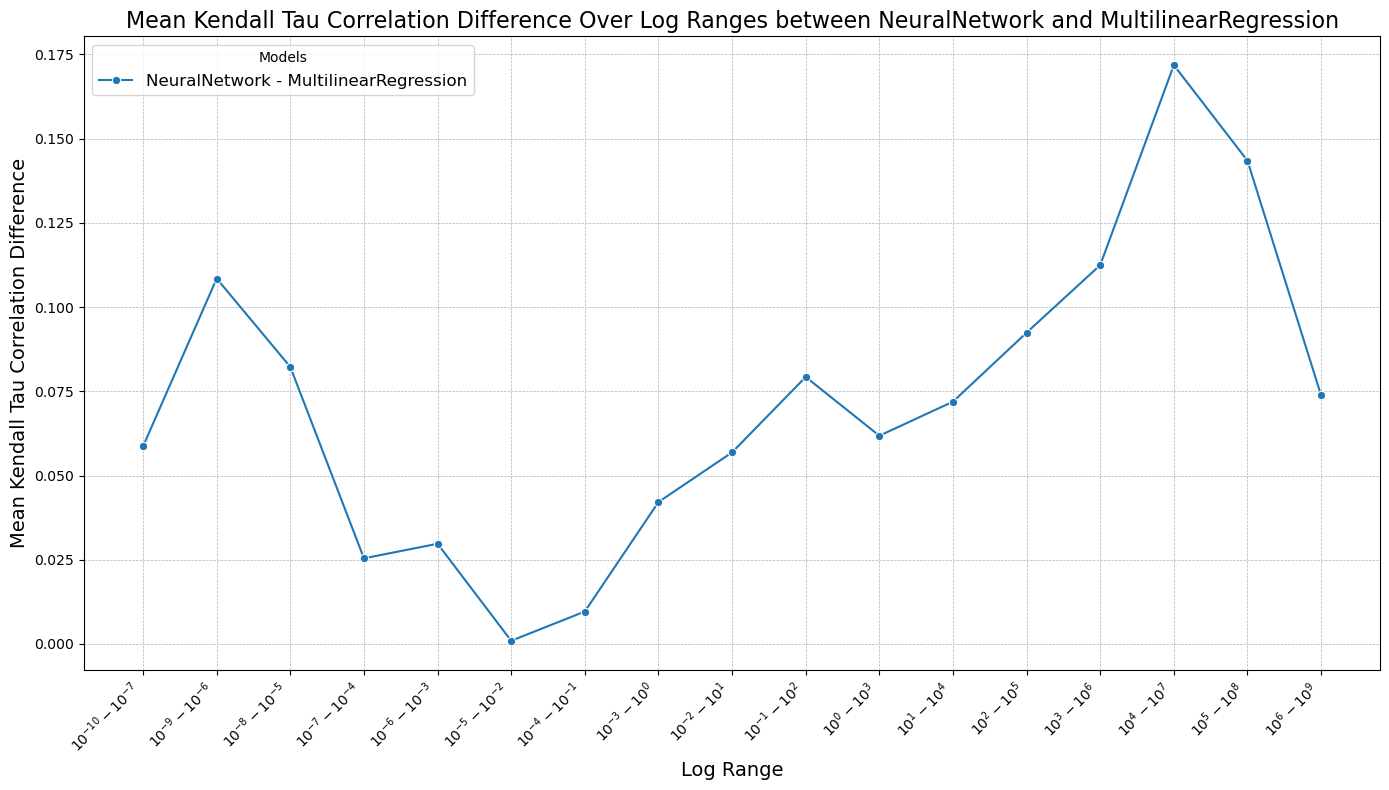

In [ ]:
#also get for each range the difference between kendall NeuralNetwork and MultilinearRegression, and plot this as lineplot
# Initialize a dictionary to store Kendall tau correlations
plot_df_minimum
mlr_mean_corrs = plot_df_minimum[plot_df_minimum['Model'] == 'MultilinearRegression']['Mean Kendall Tau'].values
nn_mean_corrs = plot_df_minimum[plot_df_minimum['Model'] == 'NeuralNetwork']['Mean Kendall Tau'].values
diff_mean_corrs = nn_mean_corrs - mlr_mean_corrs
#plot this as lineplot against log range
plt.figure(figsize=(14, 8))
sns.lineplot(
    x=plot_df_minimum['Log Range'].unique(),
    y=diff_mean_corrs,
    label='NeuralNetwork - MultilinearRegression',
    marker='o',
    ci=None,
    color=colors[0]
)
plt.xlabel('Log Range', fontsize=14)
plt.ylabel('Mean Kendall Tau Correlation Difference', fontsize=14)
plt.xticks(rotation=45, ha='right')
# #fix xticklabels; change to 10^x - 10^(x+3)
# xticklabels.append(f'$10^{{{i}}}$ - $10^{{{i + 3}}}$')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])
plt.title('Mean Kendall Tau Correlation Difference Over Log Ranges between NeuralNetwork and MultilinearRegression', fontsize=16)
plt.legend(title='Models', fontsize=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()




In [ ]:
df_vps

NameError: name 'df_vps' is not defined

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from sklearn.utils import resample

# Load data
df_vps = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/group_talk_19_09_2024/vapor_pressures_naef_opera_duplicates.csv')

# Define the log range and step size
log_ranges = [(i, i + 3) for i in range(-10, 7)]

# Initialize a dictionary to store Kendall tau correlations with bootstrapped CIs
kendall_results = {'VP OPERA': []}

# Number of bootstrap samples
num_bootstrap_samples = 1000

# Calculate Kendall tau for each log range with bootstrapping
for log_min, log_max in log_ranges:
    mask = (df_vps['VP OPERA'] >= log_min) & (df_vps['VP OPERA'] < log_max)
    if np.sum(mask) > 1:  # Ensure there are enough data points
        taus = []
        # Bootstrap resampling
        for _ in range(num_bootstrap_samples):
            sampled_data = resample(df_vps[mask], replace=True)
            if len(sampled_data) > 1:
                tau, _ = kendalltau(sampled_data['VP OPERA'], sampled_data['VP Naef&Acree'])
                taus.append(tau)

        # Calculate the mean Kendall tau and 90% CI
        mean_tau = np.nanmean(taus)
        ci_lower = np.percentile(taus, 5)
        ci_upper = np.percentile(taus, 95)
        ci_tau = (ci_upper - ci_lower) / 2  # Half-width of the 90% CI

        kendall_results['VP OPERA'].append((mean_tau, ci_tau))
    else:
        kendall_results['VP OPERA'].append((np.nan, np.nan))  # Not enough data points

# Prepare data for plotting
plot_data = []
for model_name, correlations in kendall_results.items():
    for (log_min, log_max), (mean_tau, ci_tau) in zip(log_ranges, correlations):
        plot_data.append({
            'Model': model_name,
            'Log Range': f'{log_min}-{log_max}',
            'Mean Kendall Tau': mean_tau,
            'CI (90%)': ci_tau
        })

exp_df = pd.DataFrame(plot_data)

# Display the resulting DataFrame
exp_df.head()

,Model,Log Range,Mean Kendall Tau,CI (90%)
0,VP OPERA,-10--7,0.276925,0.350150
1,VP OPERA,-9--6,0.257798,0.250000
2,VP OPERA,-8--5,0.442230,0.201567
3,VP OPERA,-7--4,0.226027,0.175544
4,VP OPERA,-6--3,0.373330,0.093449


In [ ]:
#concat
#first rename Model to Experimental
exp_df['Model'] = 'Experimental'
plot_df_combined = pd.concat([plot_df, exp_df], axis=0)
plot_df_combined

,Model,Log Range,Mean Kendall Tau,CI (90%)
0,MultilinearRegression,-10--7,0.034413,0.107370
1,MultilinearRegression,-9--6,0.257354,0.066054
2,MultilinearRegression,-8--5,0.292307,0.044883
3,MultilinearRegression,-7--4,0.306188,0.040200
4,MultilinearRegression,-6--3,0.380034,0.028865
...,...,...,...,...
12,Experimental,2-5,0.917327,0.017820
13,Experimental,3-6,0.919353,0.021291
14,Experimental,4-7,0.889979,0.033910
15,Experimental,5-8,0.815405,0.101342


In [ ]:
models_to_evaluate

['MultilinearRegression', 'NeuralNetwork']

In [ ]:
plot_df_combined_minimum = plot_df_combined[plot_df_combined['Model'].isin(models_to_evaluate + ['Experimental'])]

In [ ]:
#rename MultilinearRegression to Ordinary Least Squares
plot_df_combined_minimum['Model'] = plot_df_combined_minimum['Model'].replace({'MultilinearRegression': 'Ordinary Least Squares'})

/tmp/ipykernel_1653504/2841588881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df_combined_minimum['Model'] = plot_df_combined_minimum['Model'].replace({'MultilinearRegression': 'Ordinary Least Squares'})


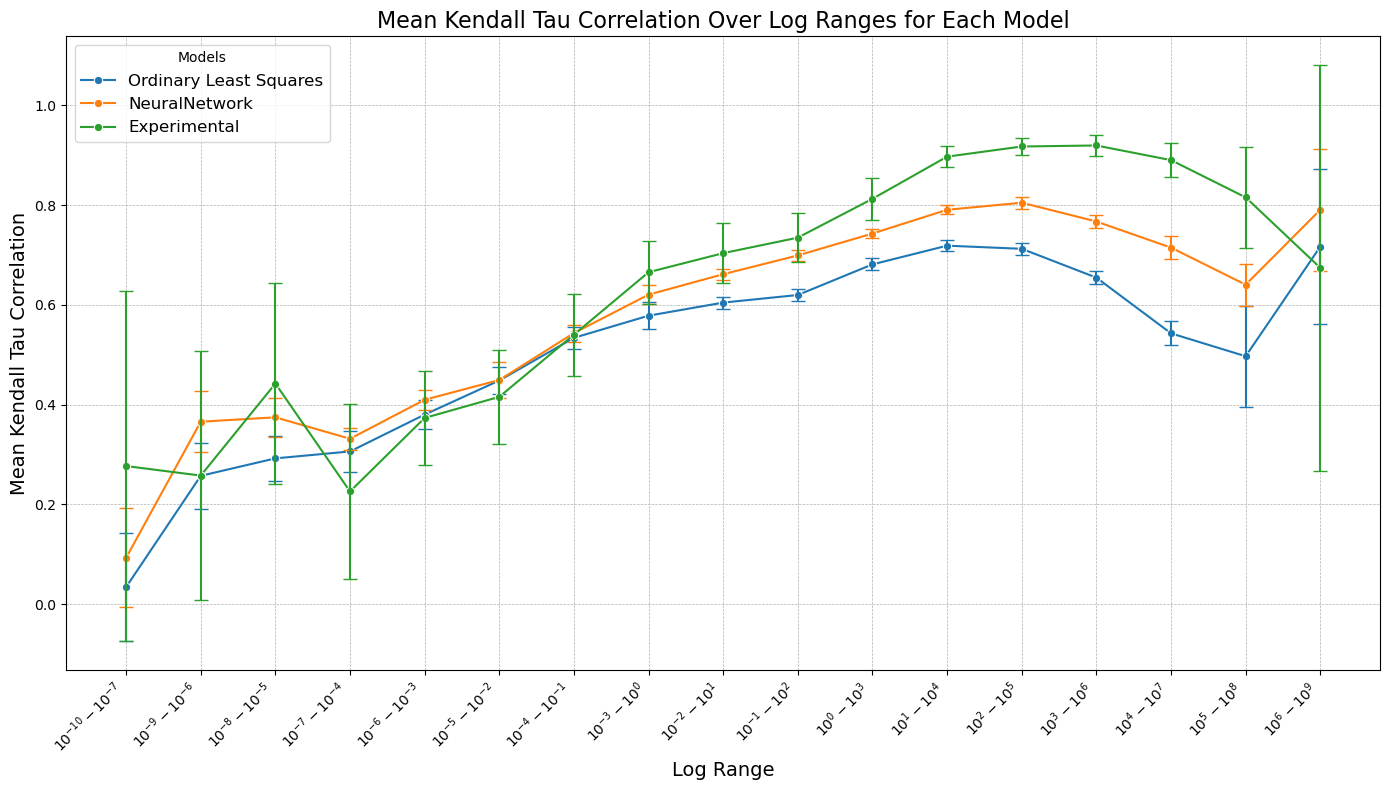

In [ ]:
plt.figure(figsize=(14, 8))
for i,model in enumerate(plot_df_combined_minimum['Model'].unique()):
    model_data = plot_df_combined_minimum[plot_df_combined_minimum['Model'] == model]
    sns.lineplot(
        x=model_data['Log Range'],
        y=model_data['Mean Kendall Tau'],
        label=model,
        marker='o',
        ci=None,
        color=colors[i]
    )
    # Plot error bars manually for 90% CI
    plt.errorbar(
        x=model_data['Log Range'],
        y=model_data['Mean Kendall Tau'],
        yerr=model_data['CI (90%)'],
        fmt='none',
        capsize=5,
        color=colors[i]
    )

plt.xlabel('Log Range', fontsize=14)
plt.ylabel('Mean Kendall Tau Correlation', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])
plt.title('Mean Kendall Tau Correlation Over Log Ranges for Each Model', fontsize=16)
plt.legend(title='Models', fontsize=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

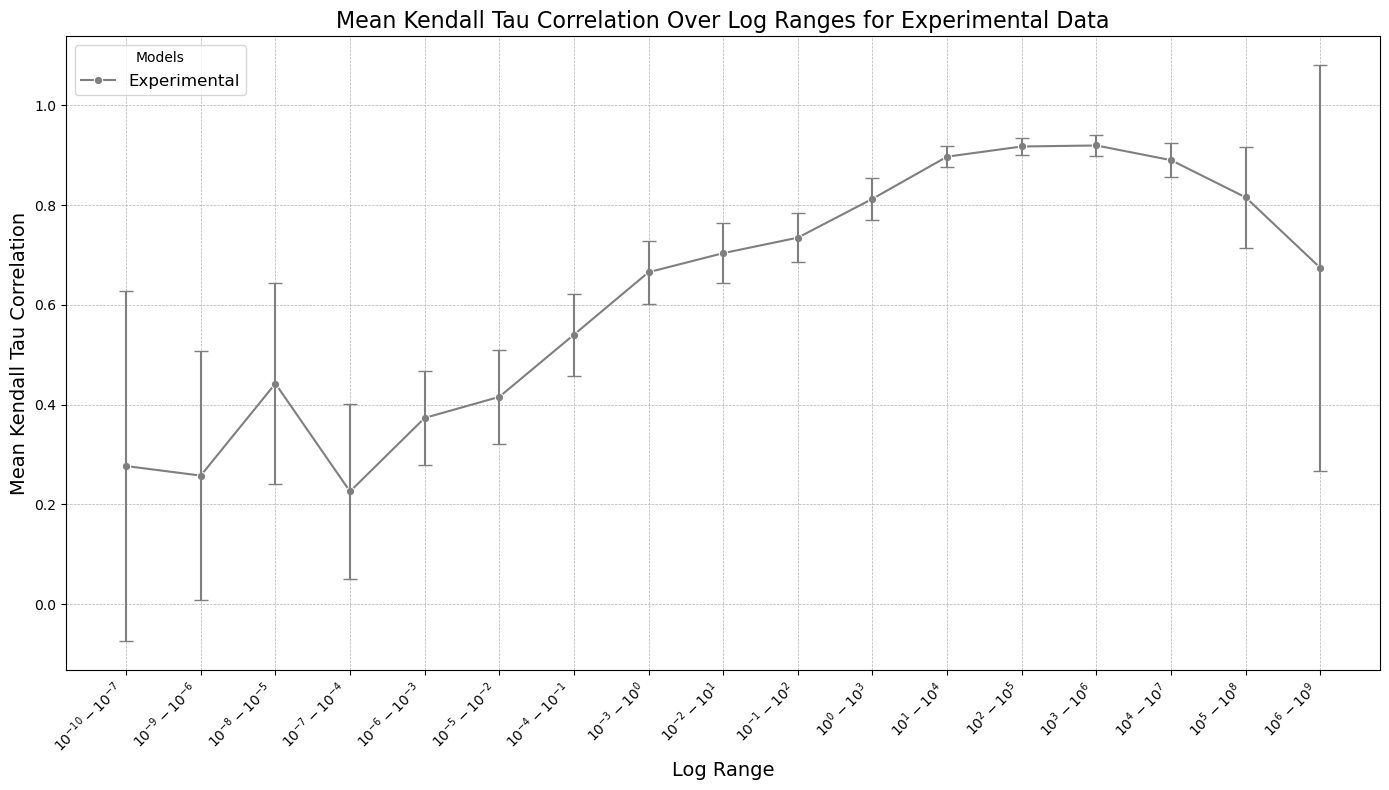

In [ ]:
#also do one with just the experimental data
plt.figure(figsize=(14, 8))
model_data = plot_df_combined_minimum[plot_df_combined_minimum['Model'] == 'Experimental']
sns.lineplot(
    x=model_data['Log Range'],
    y=model_data['Mean Kendall Tau'],
    label='Experimental',
    marker='o',
    ci=None,
    color=colors[-1]
)
plt.errorbar(
    x=model_data['Log Range'],
    y=model_data['Mean Kendall Tau'],
    yerr=model_data['CI (90%)'],
    fmt='none',
    capsize=5,
    color=colors[-1]
)

plt.xlabel('Log Range', fontsize=14)
plt.ylabel('Mean Kendall Tau Correlation', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])
plt.title('Mean Kendall Tau Correlation Over Log Ranges for Experimental Data', fontsize=16)
plt.legend(title='Models', fontsize=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()



# Maybe experiment; with different methods/descriptors, try to extrapolate in VP space?
Only possible if additive

### bootstrap below

In [ ]:
#!/usr/bin/env python

# generate a bootstrapped error estimate
# adapted from https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

from __future__ import print_function
import numpy as np
from sklearn.utils import resample
from scipy.stats import kendalltau, pearsonr, spearmanr


def bootstrap_error_estimate(pred, truth, method, method_name="", alpha=0.95, sample_frac=0.5, iterations=1000):
    """
    Generate a bootstrapped estimate of confidence intervals
    :param pred: list of predicted values
    :param truth: list of experimental values
    :param method: method to evaluate performance, e.g. matthews_corrcoef
    :param alpha: confidence limit (e.g. 0.95 for 95% confidence interval)
    :param sample_frac: fraction to resample for bootstrap confidence interval
    :param iterations: number of iterations for resampling
    :return: lower and upper bounds for confidence intervals
    """
    index_list = range(0, len(pred))
    num_samples = int(len(index_list) * sample_frac)
    stats = []
    for _ in range(0, iterations):
        sample_idx = resample(index_list, n_samples=num_samples)
        pred_sample = [pred[x] for x in sample_idx]
        truth_sample = [truth[x] for x in sample_idx]
        stats.append(method(pred_sample, truth_sample))
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    median = np.median(stats)
    return lower, upper, median

def get_kendall_tau(pred, truth):
    """
    Calculate Kendall tau correlation
    :param pred: list of predicted values
    :param truth: list of experimental values
    :return: Kendall tau correlation
    """
    return kendalltau(pred, truth).correlation

def get_pearson_r(pred, truth):
    """
    Calculate Pearson correlation
    :param pred: list of predicted values
    :param truth: list of experimental values
    :return: Pearson correlation
    """
    return pearsonr(pred, truth).correlation

def get_spearman_rho(pred, truth):
    """
    Calculate Spearman rho correlation
    :param pred: list of predicted values
    :param truth: list of experimental values
    :return: Spearman rho correlation
    """
    return spearmanr(pred, truth).correlation



In [ ]:
# Load data
#import resamle
from sklearn.utils import resample
df_vps = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/group_talk_19_09_2024/vapor_pressures_naef_opera_duplicates.csv')

# Define the log range and step size
log_ranges = [(i, i + 3) for i in range(-10, 7)]
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
# Initialize a dictionary to store Kendall tau correlations with bootstrapped CIs
metric_results = {'Kendall Tau': [], 'Pearson r' : [], 'Spearman rho' : [], 'R2' : []}
# Number of bootstrap samples
num_bootstrap_samples = 1000

# Calculate Kendall tau for each log range with bootstrapping
for log_min, log_max in log_ranges:
    mask = (df_vps['VP OPERA'] >= log_min) & (df_vps['VP OPERA'] < log_max)
    if np.sum(mask) > 1:  # Ensure there are enough data points
        taus = []
        pearsons = []
        spearmans = []
        r2s = []
        # Bootstrap resampling
        for _ in range(num_bootstrap_samples):
            sampled_data = resample(df_vps[mask], replace=True)
            if len(sampled_data) > 1:
                tau, _ = kendalltau(sampled_data['VP OPERA'], sampled_data['VP Naef&Acree'])
                taus.append(tau)
                pearson, _ = pearsonr(sampled_data['VP OPERA'], sampled_data['VP Naef&Acree'])
                pearsons.append(pearson)
                spearman, _ = spearmanr(sampled_data['VP OPERA'], sampled_data['VP Naef&Acree'])
                spearmans.append(spearman)
                r2 = r2_score(sampled_data['VP OPERA'], sampled_data['VP Naef&Acree'])
                r2s.append(r2)


        # Calculate the mean Kendall tau and 90% CI
        mean_tau = np.nanmean(taus)
        ci_lower = np.percentile(taus, 5)
        ci_upper = np.percentile(taus, 95)
        ci_tau = (ci_upper - ci_lower) / 2  # Half-width of the 90% CI
        metric_results['Kendall Tau'].append((mean_tau, ci_tau))
        mean_pearson = np.nanmean(pearsons)
        ci_lower = np.percentile(pearsons, 5)
        ci_upper = np.percentile(pearsons, 95)
        ci_pearson = (ci_upper - ci_lower) / 2
        metric_results['Pearson r'].append((mean_pearson, ci_pearson))
        mean_spearman = np.nanmean(spearmans)
        ci_lower = np.percentile(spearmans, 5)
        ci_upper = np.percentile(spearmans, 95)
        ci_spearman = (ci_upper - ci_lower) / 2
        metric_results['Spearman rho'].append((mean_spearman, ci_spearman))
        mean_r2 = np.nanmean(r2s)
        ci_lower = np.percentile(r2s, 5)
        ci_upper = np.percentile(r2s, 95)
        ci_r2 = (ci_upper - ci_lower) / 2
        metric_results['R2'].append((mean_r2, ci_r2))

    else:
        metric_results['Kendall Tau'].append((np.nan, np.nan))
        metric_results['Pearson r'].append((np.nan, np.nan))
        metric_results['Spearman rho'].append((np.nan, np.nan))
        metric_results['R2'].append((np.nan, np.nan))

# Prepare data for plotting
plot_data = []
for model_name, correlations in metric_results.items():
    for (log_min, log_max), (mean_tau, ci_tau) in zip(log_ranges, correlations):
        plot_data.append({
            'Model': model_name,
            'Log Range': f'{log_min}-{log_max}',
            'Mean Metric': mean_tau,
            'CI (90%)': ci_tau
        })

metric_df = pd.DataFrame(plot_data)
metric_df

,Model,Log Range,Mean Metric,CI (90%)
0,Kendall Tau,-10--7,0.262650,0.351688
1,Kendall Tau,-9--6,0.253394,0.250000
2,Kendall Tau,-8--5,0.445412,0.196876
3,Kendall Tau,-7--4,0.224384,0.181576
4,Kendall Tau,-6--3,0.372124,0.101671
...,...,...,...,...
63,R2,2-5,0.971434,0.010008
64,R2,3-6,0.965388,0.018501
65,R2,4-7,0.936920,0.044599
66,R2,5-8,0.794400,0.178507


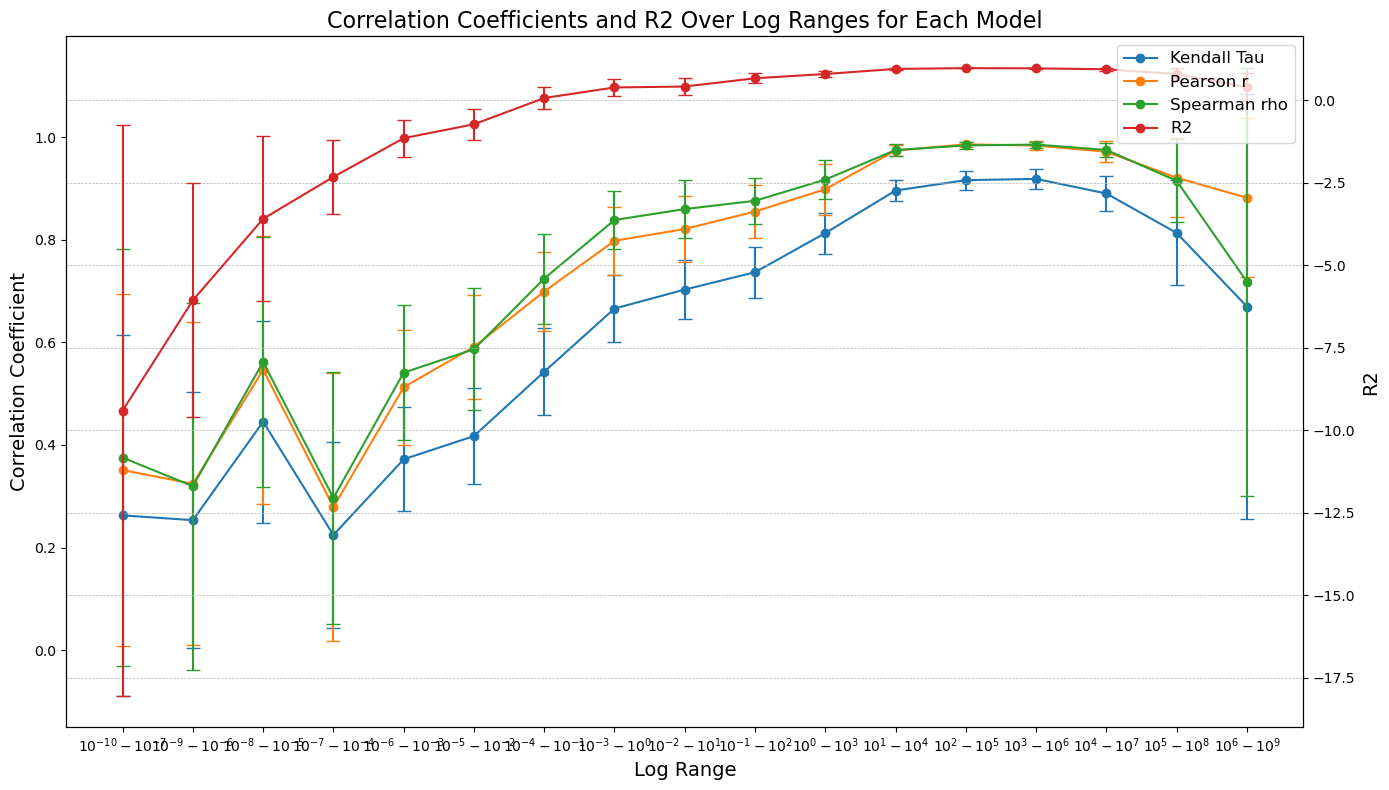

In [ ]:
#plot on twin axes, one for correlations and one for r2
# Initialize the figure
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Kendall Tau , Pearson r, Spearman rho
for i, metric in enumerate(['Kendall Tau', 'Pearson r', 'Spearman rho']):
    model_data = metric_df[metric_df['Model'] == metric]
    ax1.plot(
        model_data['Log Range'],
        model_data['Mean Metric'],
        label=metric,
        marker='o',
        color=colors[i]
    )
    # Plot error bars manually for 90% CI
    ax1.errorbar(
        model_data['Log Range'],
        model_data['Mean Metric'],
        yerr=model_data['CI (90%)'],
        fmt='none',
        capsize=5,
        color=colors[i]
    )

# Create a second y-axis for R2
ax2 = ax1.twinx()
model_data = metric_df[metric_df['Model'] == 'R2']
ax2.plot(
    model_data['Log Range'],
    model_data['Mean Metric'],
    label='R2',
    marker='o',
    color=colors[3]
)
# Plot error bars manually for 90% CI
ax2.errorbar(
    model_data['Log Range'],
    model_data['Mean Metric'],
    yerr=model_data['CI (90%)'],
    fmt='none',
    capsize=5,
    color=colors[3]
)

# Set labels and title
ax1.set_xlabel('Log Range', fontsize=14)
ax1.set_ylabel('Correlation Coefficient', fontsize=14)
ax2.set_ylabel('R2', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])
plt.title('Correlation Coefficients and R2 Over Log Ranges for Each Model', fontsize=16)
# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()



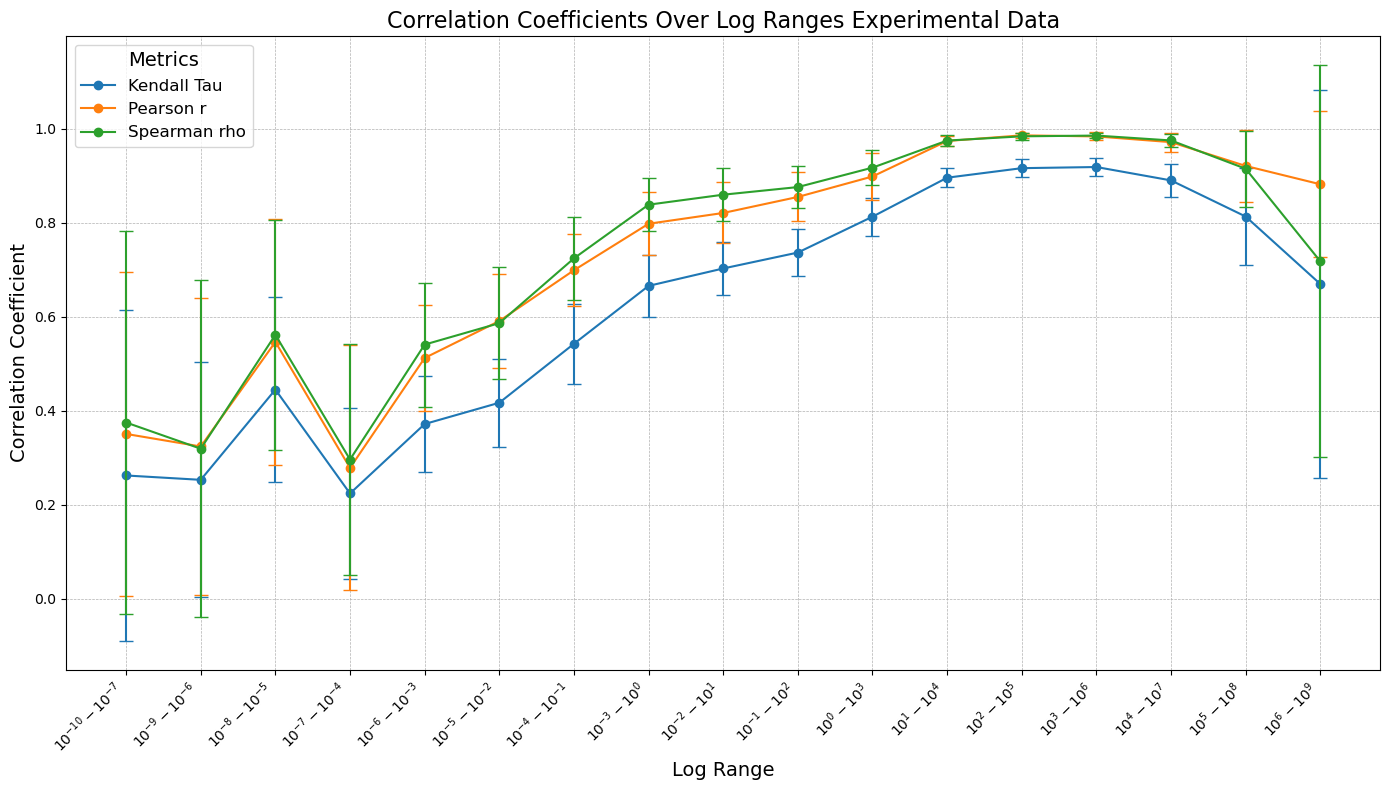

In [ ]:
#plot on twin axes, one for correlations and one for r2
# Initialize the figure
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Kendall Tau , Pearson r, Spearman rho
for i, metric in enumerate(['Kendall Tau', 'Pearson r', 'Spearman rho']):
    model_data = metric_df[metric_df['Model'] == metric]
    ax1.plot(
        model_data['Log Range'],
        model_data['Mean Metric'],
        label=metric,
        marker='o',
        color=colors[i]
    )
    # Plot error bars manually for 90% CI
    ax1.errorbar(
        model_data['Log Range'],
        model_data['Mean Metric'],
        yerr=model_data['CI (90%)'],
        fmt='none',
        capsize=5,
        color=colors[i]
    )


# Set labels and title
ax1.set_xlabel('Log Range', fontsize=14)
ax1.set_ylabel('Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])
plt.title('Correlation Coefficients Over Log Ranges Experimental Data', fontsize=16)

plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.legend(title='Metrics', fontsize=12, title_fontsize=14)
plt.show()



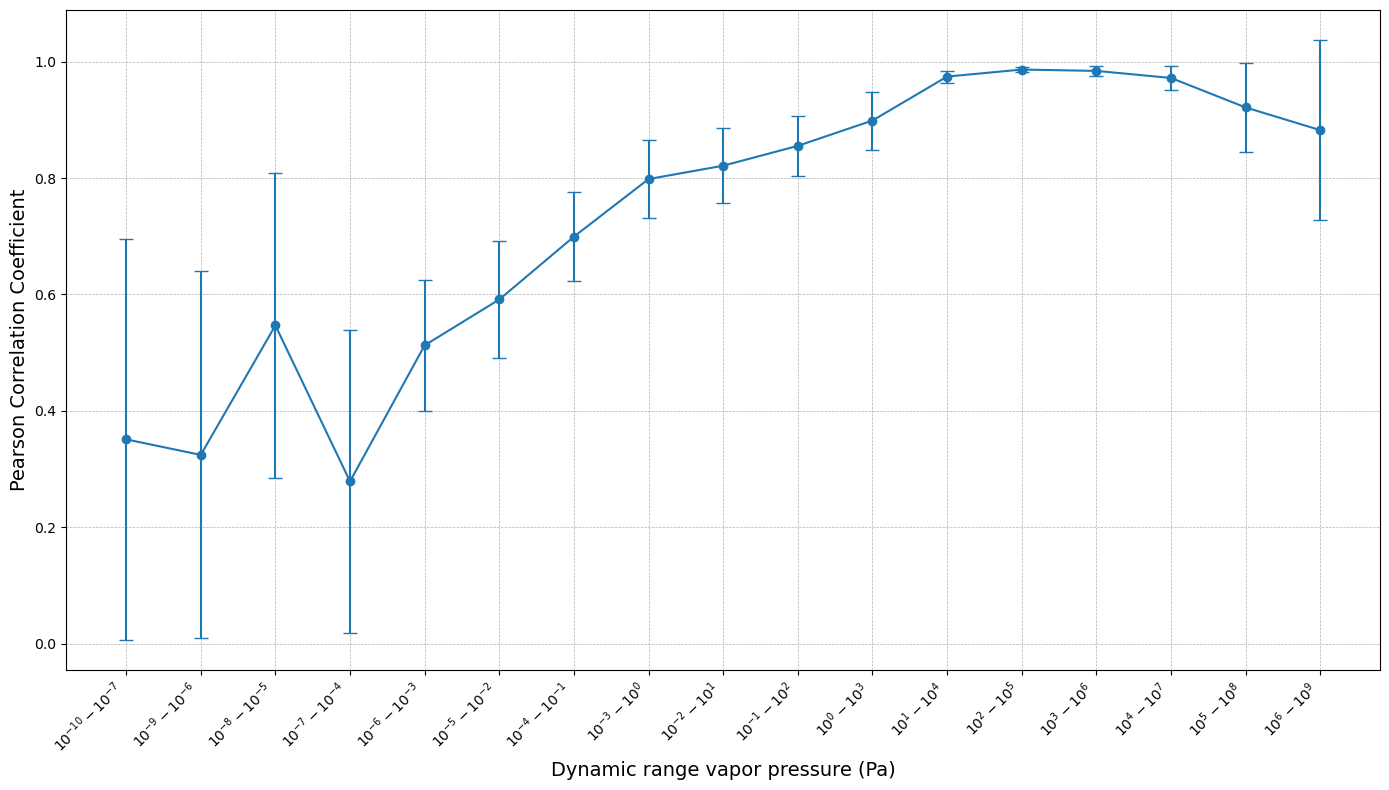

In [ ]:
#plot on twin axes, one for correlations and one for r2
# Initialize the figure
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Kendall Tau , Pearson r, Spearman rho
model_data = metric_df[metric_df['Model'] == 'Pearson r']
ax1.plot(
    model_data['Log Range'],
    model_data['Mean Metric'],
    label=metric,
    marker='o',
    color=colors[0]
)
# Plot error bars manually for 90% CI
ax1.errorbar(
    model_data['Log Range'],
    model_data['Mean Metric'],
    yerr=model_data['CI (90%)'],
    fmt='none',
    capsize=5,
    color=colors[0]
)


# Set labels and title
ax1.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])

plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.savefig('pearson_correlation_coefficient_OPERA_naef_bootstrap.png', dpi=800)
plt.show()



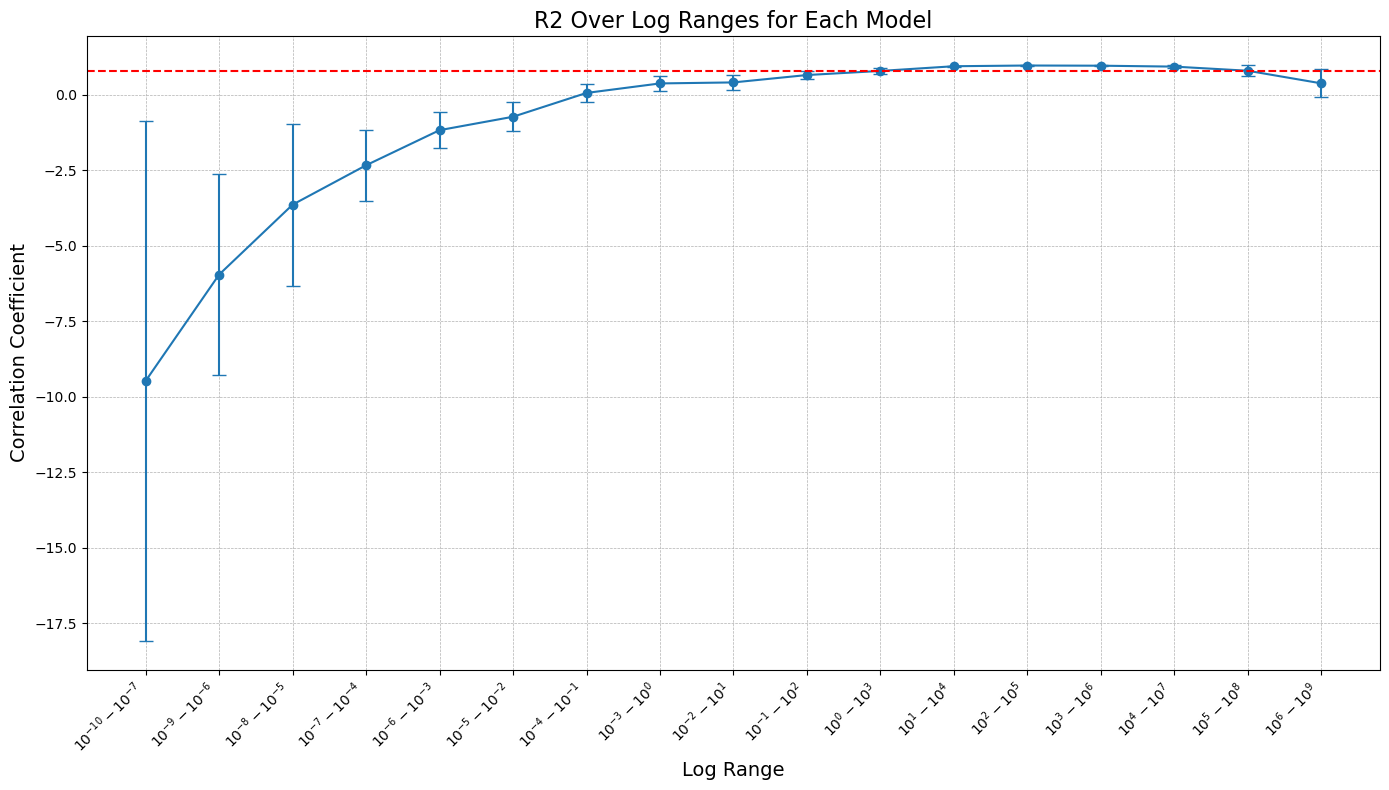

In [ ]:
#plot on twin axes, one for correlations and one for r2
# Initialize the figure
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Kendall Tau , Pearson r, Spearman rho
model_data = metric_df[metric_df['Model'] == 'R2']
ax1.plot(
    model_data['Log Range'],
    model_data['Mean Metric'],
    label=metric,
    marker='o',
    color=colors[0]
)
# Plot error bars manually for 90% CI
ax1.errorbar(
    model_data['Log Range'],
    model_data['Mean Metric'],
    yerr=model_data['CI (90%)'],
    fmt='none',
    capsize=5,
    color=colors[0]
)


# Set labels and title
ax1.set_xlabel('Log Range', fontsize=14)
ax1.set_ylabel('Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xticks(np.arange(len(log_ranges)), [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges])
plt.title('R2 Over Log Ranges for Each Model', fontsize=16)
#draw horizontal line at 0.5
plt.axhline(y=0.8, color='r', linestyle='--')
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()



In [ ]:
#code from Pat
#!/usr/bin/env python

# generate a bootstrapped error estimate
# adapted from https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

from __future__ import print_function
import numpy as np
from sklearn.utils import resample
from scipy.stats import kendalltau, pearsonr, spearmanr


def bootstrap_error_estimate(pred, truth, method, method_name="", alpha=0.95, sample_frac=0.9, iterations=1000):
    """
    Generate a bootstrapped estimate of confidence intervals
    :param pred: list of predicted values
    :param truth: list of experimental values
    :param method: method to evaluate performance, e.g. matthews_corrcoef
    :param alpha: confidence limit (e.g. 0.95 for 95% confidence interval)
    :param sample_frac: fraction to resample for bootstrap confidence interval
    :param iterations: number of iterations for resampling
    :return: lower and upper bounds for confidence intervals
    """
    index_list = range(0, len(pred))
    num_samples = int(len(index_list) * sample_frac)
    stats = []
    for _ in range(0, iterations):
        sample_idx = resample(index_list, n_samples=num_samples)
        pred_sample = [pred[x] for x in sample_idx]
        truth_sample = [truth[x] for x in sample_idx]
        stats.append(method(pred_sample, truth_sample))
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    if method_name in ["root_mean_squared_error", "mean_absolute_error"]:
        upper = np.percentile(stats, p)
    else:
        upper = min(1.0, np.percentile(stats, p))
    median = method(pred, truth)
    return lower, upper, median

def get_kendall_tau(pred, truth):
    """
    Calculate Kendall tau correlation
    :param pred: list of predicted values
    :param truth: list of experimental values
    :return: Kendall tau correlation
    """
    return kendalltau(pred, truth).correlation

def get_pearson_r(pred, truth):
    """
    Calculate Pearson correlation
    :param pred: list of predicted values
    :param truth: list of experimental values
    :return: Pearson correlation
    """
    return pearsonr(pred, truth).correlation

def get_spearman_rho(pred, truth):
    """
    Calculate Spearman rho correlation
    :param pred: list of predicted values
    :param truth: list of experimental values
    :return: Spearman rho correlation
    """
    return spearmanr(pred, truth).correlation

def get_fraction_withing_1_log(pred, truth):
    """
    Calculate the fraction of predicted values that are within 1 log of the experimental values
    :param pred: list of predicted values
    :param truth: list of experimental values
    :return: fraction of predicted values within 1 log of the experimental values
    """
    return np.mean(np.abs(np.array(pred) - np.array(truth)) < 1)
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

# Initialize a dictionary to store the bootstrapped error estimates
bootstrap_results = {'Log Range': [], 'Kendall Tau': [], 'Pearson r': [], 'Spearman rho': [], 'R2': [],'N': [], 'RMSE': [], 'MAE': [], 'Fraction within 1 log': []}

#get the bootstrapped error estimates for the different metrics, over the different log ranges
for i in range(-12, 10, 1):
    df_tmp = df_vps[(df_vps['VP OPERA'] >= i) & (df_vps['VP OPERA'] < i+3)]
    if len(df_tmp) > 5:
        kendall_result = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, get_kendall_tau,method_name="get_kendall_tau")
        pearson_result = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, get_pearson_r,method_name="get_pearson_r")
        spearman_result = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, get_spearman_rho,method_name="get_spearman_rho")
        r2_result = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, r2_score,method_name="r2_score")
        rmse_result = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, root_mean_squared_error,method_name="root_mean_squared_error")
        mae_result = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, mean_absolute_error,method_name="mean_absolute_error")
        fraction_result = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, get_fraction_withing_1_log,method_name="get_fraction_withing_1_log")
    
        #assert all have no nans, else continue
        if np.isnan(kendall_result[0]) or np.isnan(pearson_result[0]) or np.isnan(spearman_result[0]) or np.isnan(r2_result[0]):
            continue

        # Save the results for plotting later
        bootstrap_results['Log Range'].append(f'{i}-{i+3}')
        bootstrap_results['Kendall Tau'].append(kendall_result)
        bootstrap_results['Pearson r'].append(pearson_result)
        bootstrap_results['Spearman rho'].append(spearman_result)
        bootstrap_results['R2'].append(r2_result)
        bootstrap_results['N'].append(len(df_tmp))
        bootstrap_results['RMSE'].append(rmse_result)
        bootstrap_results['MAE'].append(mae_result)
        bootstrap_results['Fraction within 1 log'].append(fraction_result)
        

# Convert the results to a DataFrame for easier plotting
bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_df.head()

,Log Range,Kendall Tau,Pearson r,Spearman rho,R2,N,RMSE,MAE,Fraction within 1 log
0,-11--8,"(0.0, 0.7419742070594567, 0.26967994498529685)","(0.0, 0.9767057888865371, 0.43955037151240706)","(0.0, 0.8584862552734253, 0.4559291577600484)","(0.0, -0.3217334381990514, -1.8450464415230146)",10,"(1.9230279821803555, 3.566869650920496, 2.6914...","(1.7368526384538407, 3.2627567891345732, 2.424...","(0.0, 0.4444444444444444, 0.2)"
1,-10--7,"(0.0, 0.6976744186046512, 0.26890756302521013)","(0.0, 0.7668146897928579, 0.3543996974711039)","(0.0, 0.8429499426327082, 0.4050073637702503)","(0.0, -0.19194320424410183, -1.6512484546614776)",16,"(1.7006118730058333, 3.021173318233045, 2.2976...","(1.3547733802725015, 2.6316424929252387, 1.968...","(0.07142857142857142, 0.5, 0.25)"
2,-9--6,"(0.0, 0.5788143758419677, 0.2545454545454545)","(0.0, 0.7128121462516622, 0.3221696483190517)","(0.0, 0.6998001882037642, 0.33188342757720746)","(0.0, -0.6149117681389147, -1.69098954073907)",24,"(1.4975054576414732, 2.8156663265009345, 2.195...","(1.2168486304332902, 2.372359696446143, 1.7605...","(0.09523809523809523, 0.47619047619047616, 0.2..."
3,-8--5,"(0.15855313398908458, 0.6710197503270334, 0.44...","(0.11430085414034703, 0.8174661113531133, 0.55...","(0.17521480383391744, 0.8176085513581592, 0.56...","(0.0, -0.00281565377826843, -0.7010214625406543)",33,"(1.2760040472019283, 2.138556199855552, 1.6648...","(1.0401867242899052, 1.7338299405442505, 1.369...","(0.1724137931034483, 0.5172413793103449, 0.333..."
4,-7--4,"(0.0, 0.4452378324326446, 0.22651152946206823)","(0.0, 0.6054985803886427, 0.2819598979062828)","(0.0, 0.58009942895677, 0.30386740726836325)","(0.0, -0.04041580466584241, -0.588419020322432)",53,"(1.1955237464552246, 1.8156617430057544, 1.489...","(1.0257858133967614, 1.4700961800964871, 1.236...","(0.2127659574468085, 0.48936170212765956, 0.35..."


In [1]:
#save
bootstrap_df.to_csv('bootstrap_results_naef.csv', index=False)

NameError: name 'bootstrap_df' is not defined

In [175]:
df_tmp = df_vps[(df_vps['VP OPERA'] >= -10) & (df_vps['VP OPERA'] < -7)]
pred = df_tmp['VP Naef&Acree'].values
truth = df_tmp['VP OPERA'].values
sample_frac = 0.9
iterations = 1000
method = mean_absolute_error
method = get_kendall_tau
alpha = 0.95
index_list = range(0, len(pred))
num_samples = int(len(index_list) * sample_frac)
stats = []
for _ in range(0, iterations):
    sample_idx = resample(index_list, n_samples=num_samples)
    pred_sample = [pred[x] for x in sample_idx]
    truth_sample = [truth[x] for x in sample_idx]
    stats.append(method(pred_sample, truth_sample))
p = ((1.0 - alpha) / 2.0) * 100
lower = np.percentile(stats, p)
p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = np.percentile(stats, p)
median = method(pred, truth)
print(lower, upper, median) 

-0.2250238465091013 0.6904761904761906 0.26890756302521013


/tmp/ipykernel_1787826/1644019333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_ktau[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_ktau['Kendall Tau'].tolist(), index=bootstrap_df_ktau.index)
/tmp/ipykernel_1787826/1644019333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_ktau[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_ktau['Kendall Tau'].tolist(), index=bootstrap_df_ktau.index)
/tmp/ipykernel_1787826/1644019333.py:2: SettingWithCopyWarning: 
A val

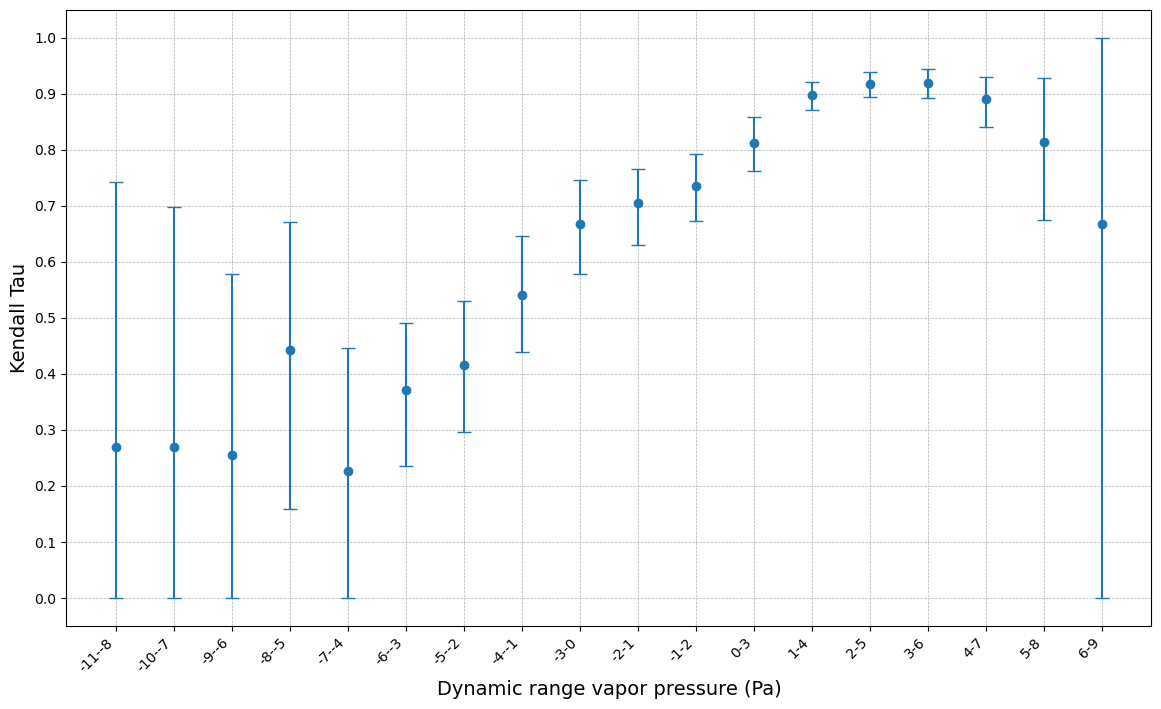

/tmp/ipykernel_1787826/1644019333.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_pearson[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_pearson['Pearson r'].tolist(), index=bootstrap_df_pearson.index)
/tmp/ipykernel_1787826/1644019333.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_pearson[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_pearson['Pearson r'].tolist(), index=bootstrap_df_pearson.index)
/tmp/ipykernel_1787826/1644019333.py:32: SettingWithCo

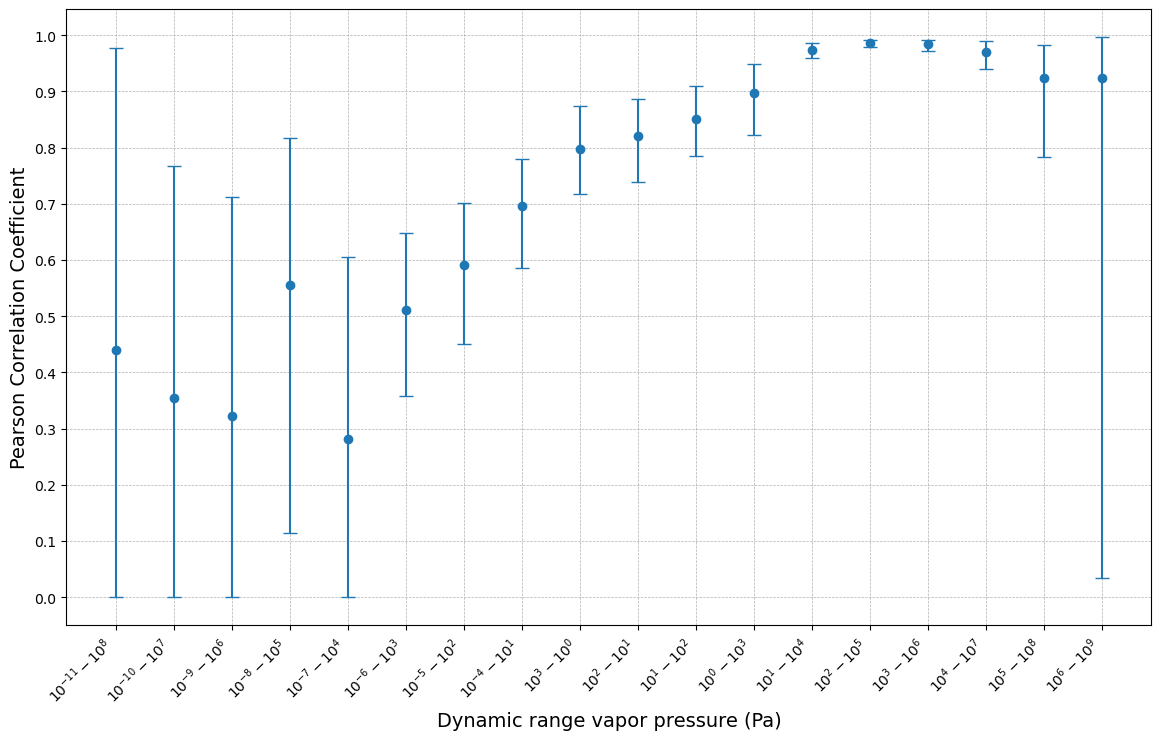

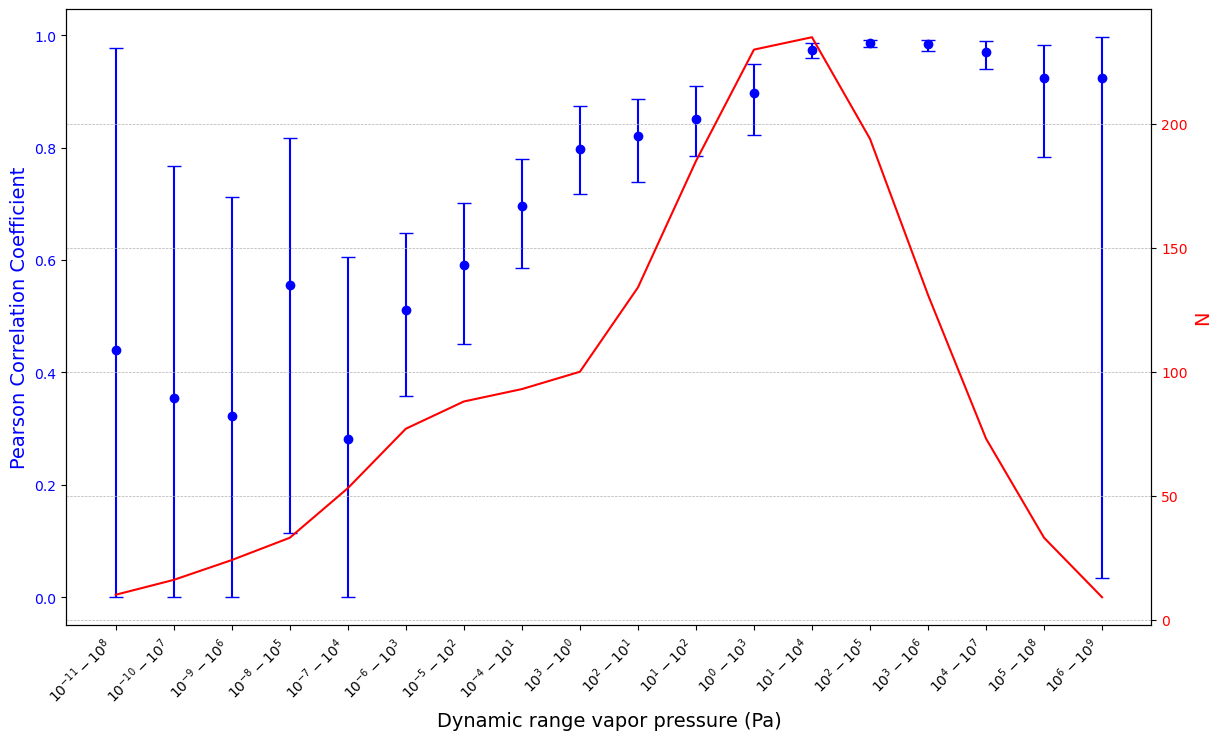

In [180]:
bootstrap_df_ktau = bootstrap_df[['Log Range', 'Kendall Tau',"N"]]
bootstrap_df_ktau[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_ktau['Kendall Tau'].tolist(), index=bootstrap_df_ktau.index)
bootstrap_df_ktau = bootstrap_df_ktau.dropna()
y_val = bootstrap_df_ktau['Mean']
lb = y_val - bootstrap_df_ktau['Lower']
ub = bootstrap_df_ktau['Upper'] - y_val

plt.figure(figsize=(14, 8))
plt.errorbar(bootstrap_df_ktau['Log Range'], y_val, yerr=[lb, ub], fmt='o', capsize=5)
plt.xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
plt.ylabel('Kendall Tau', fontsize=14)
plt.xticks(rotation=45, ha='right')

log_ranges = bootstrap_df_ktau['Log Range']
# long_ranges_new = [(-int(i.split('-')[1]), int(i.split('-')[3])) for i in log_ranges if len(i.split('-')[0]) == 1 else (int(i.split('-')[0]), int(i.split('-')[1]))]
long_ranges_new = []
for l in log_ranges:
    if len(l.split('-')) == 4:
        long_ranges_new.append((-int(l.split('-')[1]), int(l.split('-')[3])))
    elif len(l.split('-')) == 3:
        long_ranges_new.append((int(l.split('-')[1]), int(l.split('-')[2])))
    else:
        long_ranges_new.append((int(l.split('-')[0]), int(l.split('-')[1])))
long_ranges_lower = [l[0] for l in long_ranges_new]
log_ranges_upper = [l[1] for l in long_ranges_new]
xtick_labels = [f'$10^{{{lower}}} - 10^{{{upper}}}$' for lower, upper in zip(long_ranges_lower, log_ranges_upper)]
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()
#do same for pearson
bootstrap_df_pearson = bootstrap_df[['Log Range', 'Pearson r','N']]
bootstrap_df_pearson[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_pearson['Pearson r'].tolist(), index=bootstrap_df_pearson.index)
y_val = bootstrap_df_pearson['Mean']
lb = y_val - bootstrap_df_pearson['Lower']
ub = bootstrap_df_pearson['Upper'] - y_val
plt.figure(figsize=(14, 8))
plt.errorbar(bootstrap_df_pearson['Log Range'], y_val, yerr=[lb, ub], fmt='o', capsize=5)
plt.xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
plt.ylabel('Pearson Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right')
xtick_labels = [f'$10^{{{lower}}} - 10^{{{upper}}}$' for lower, upper in zip(long_ranges_lower, log_ranges_upper)]
plt.xticks(np.arange(len(log_ranges)), xtick_labels)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()
#do twin axis with pearson and N
fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.errorbar(bootstrap_df_pearson['Log Range'], bootstrap_df_pearson['Mean'], yerr=[lb, ub], fmt='o', capsize=5, color='b')
ax1.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=14, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(bootstrap_df_pearson['Log Range'], bootstrap_df_pearson['N'], 'r-')
ax2.set_ylabel('N', fontsize=14, color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.xticks(rotation=45, ha='right')
plt.xticks(np.arange(len(log_ranges)), xtick_labels)
#they are not rotated now
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()



/tmp/ipykernel_1787826/1002817209.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', 256)


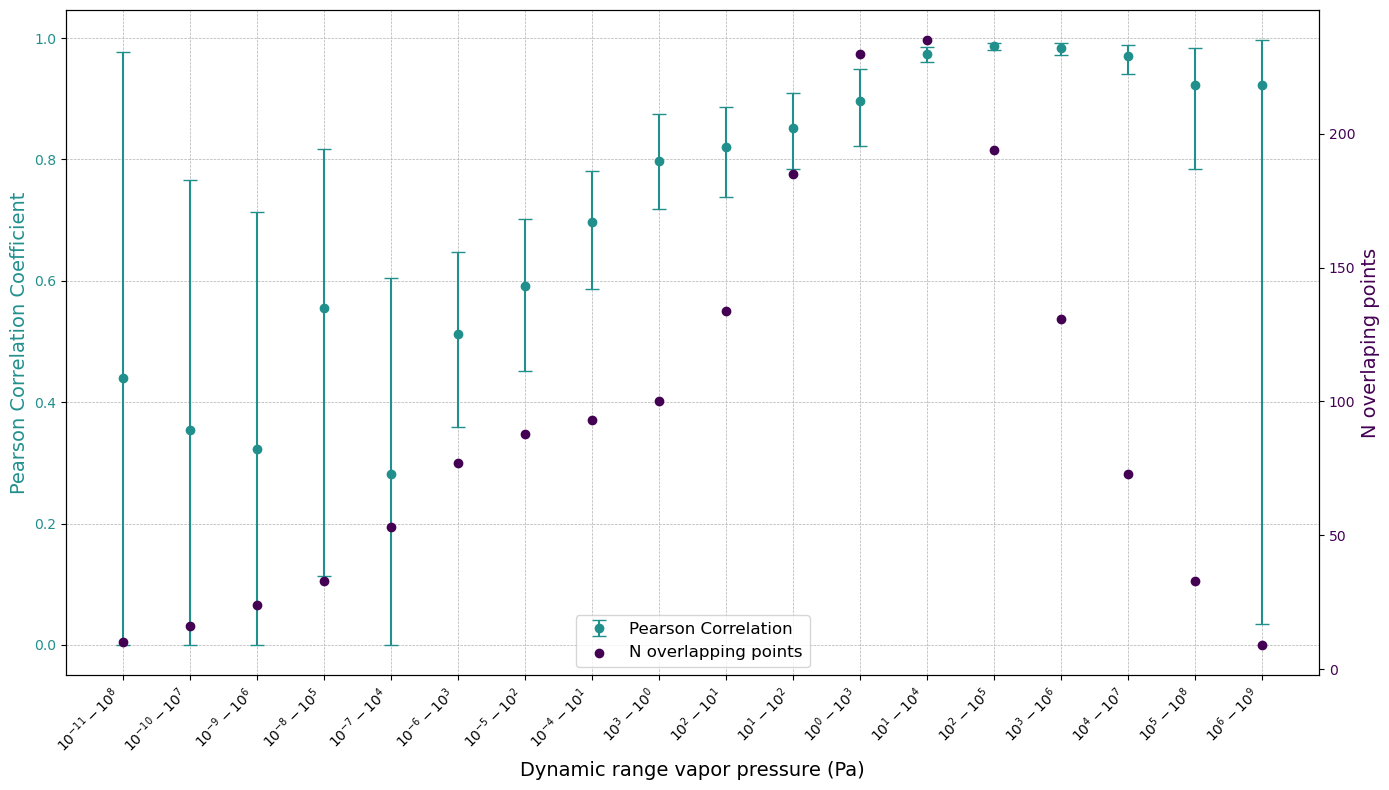

/tmp/ipykernel_1787826/1002817209.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', 256)


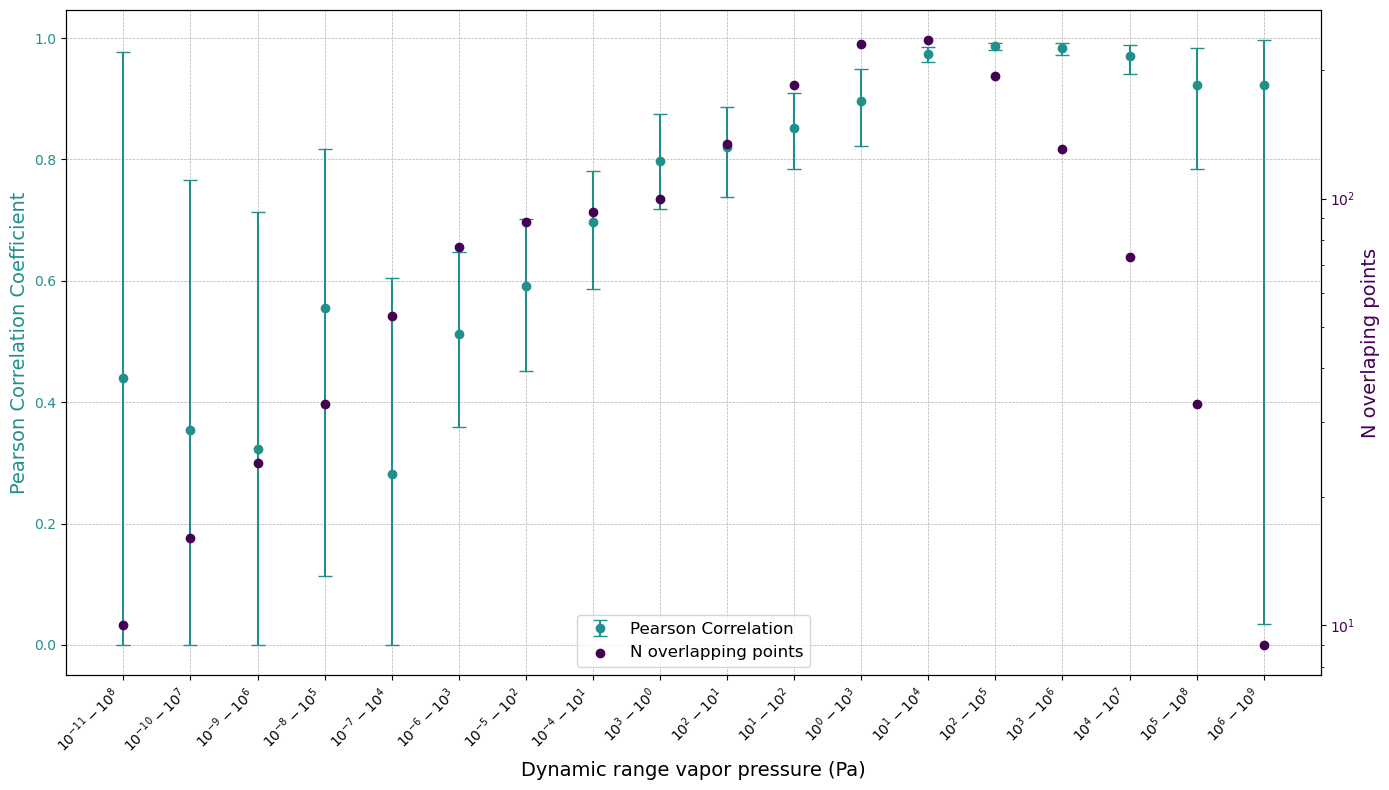

In [182]:
import matplotlib.pyplot as plt
import numpy as np

# Define a more harmonious color scheme
# pearson_color = '#1f77b4'  # A soft blue for Pearson correlation
# n_color = '#ff7f0e'        # A soft orange for N
n_color = 'darkgreen'
pearson_color = 'darkblue'
#get viridis colors, but only dark ones
import matplotlib.cm as cm
colors = cm.get_cmap('viridis', 256)
colors = colors(np.linspace(0, 1, 256))
colors = colors[:128]
colors = colors[::-1]
pearson_color = colors[0]
n_color = colors[-1]
bootstrap_df_pearson = bootstrap_df_pearson.dropna()
long_ranges_new = []
for l in bootstrap_df_pearson['Log Range']:
    if len(l.split('-')) == 4:
        long_ranges_new.append((-int(l.split('-')[1]), int(l.split('-')[3])))
    elif len(l.split('-')) == 3:
        long_ranges_new.append((int(l.split('-')[1]), int(l.split('-')[2])))
    else:
        long_ranges_new.append((int(l.split('-')[0]), int(l.split('-')[1])))
long_ranges_lower = [l[0] for l in long_ranges_new]
log_ranges_upper = [l[1] for l in long_ranges_new]
xtick_labels = [f'$10^{{{lower}}} - 10^{{{upper}}}$' for lower, upper in zip(long_ranges_lower, log_ranges_upper)]
                
# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(14, 8))
lb = bootstrap_df_pearson['Mean'] - bootstrap_df_pearson['Lower']
ub = bootstrap_df_pearson['Upper'] - bootstrap_df_pearson['Mean']


# Plot Pearson correlation with error bars
ax1.errorbar(
    bootstrap_df_pearson['Log Range'], 
    bootstrap_df_pearson['Mean'], 
    yerr=[lb, ub], 
    fmt='o', 
    capsize=5, 
    color=pearson_color,
    label='Pearson Correlation'
)

# Customize the first axis
ax1.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=14, color=pearson_color)
ax1.tick_params(axis='y', labelcolor=pearson_color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(visible=True, linestyle='--', linewidth=0.5)

# Customize x-tick labels with scientific notation
ax1.set_xticks(np.arange(len(log_ranges)))
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Create the second axis for N
ax2 = ax1.twinx()
ax2.scatter(bootstrap_df_pearson['Log Range'], bootstrap_df_pearson['N'], color=n_color, label='N overlapping points')

# Customize the second axis
ax2.set_ylabel('N overlaping points', fontsize=14, color=n_color)
ax2.tick_params(axis='y', labelcolor=n_color)

# combine legend and put in lower center
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower center', fontsize=12)


# Set a tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Define a more harmonious color scheme
# pearson_color = '#1f77b4'  # A soft blue for Pearson correlation
# n_color = '#ff7f0e'        # A soft orange for N
n_color = 'darkgreen'
pearson_color = 'darkblue'
#get viridis colors, but only dark ones
import matplotlib.cm as cm
colors = cm.get_cmap('viridis', 256)
colors = colors(np.linspace(0, 1, 256))
colors = colors[:128]
colors = colors[::-1]
pearson_color = colors[0]
n_color = colors[-1]

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Pearson correlation with error bars
ax1.errorbar(
    bootstrap_df_pearson['Log Range'], 
    bootstrap_df_pearson['Mean'], 
    yerr=[lb, ub], 
    fmt='o', 
    capsize=5, 
    color=pearson_color,
    label='Pearson Correlation'
)

# Customize the first axis
ax1.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=14, color=pearson_color)
ax1.tick_params(axis='y', labelcolor=pearson_color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(visible=True, linestyle='--', linewidth=0.5)

# Customize x-tick labels with scientific notation
ax1.set_xticks(np.arange(len(log_ranges)))
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Create the second axis for N
ax2 = ax1.twinx()
ax2.scatter(bootstrap_df_pearson['Log Range'], bootstrap_df_pearson['N'], color=n_color, label='N overlapping points')
#set the y-axis to log scale
ax2.set_yscale('log')
# Customize the second axis
ax2.set_ylabel('N overlaping points', fontsize=14, color=n_color)
ax2.tick_params(axis='y', labelcolor=n_color)

# combine legend and put in lower center
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower center', fontsize=12)


# Set a tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


/tmp/ipykernel_1787826/1741557395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
/tmp/ipykernel_1787826/1741557395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
/tmp/ipykernel_1787826/1741557395.py:4: SettingWithCopyWarning: 
A value is trying to be set

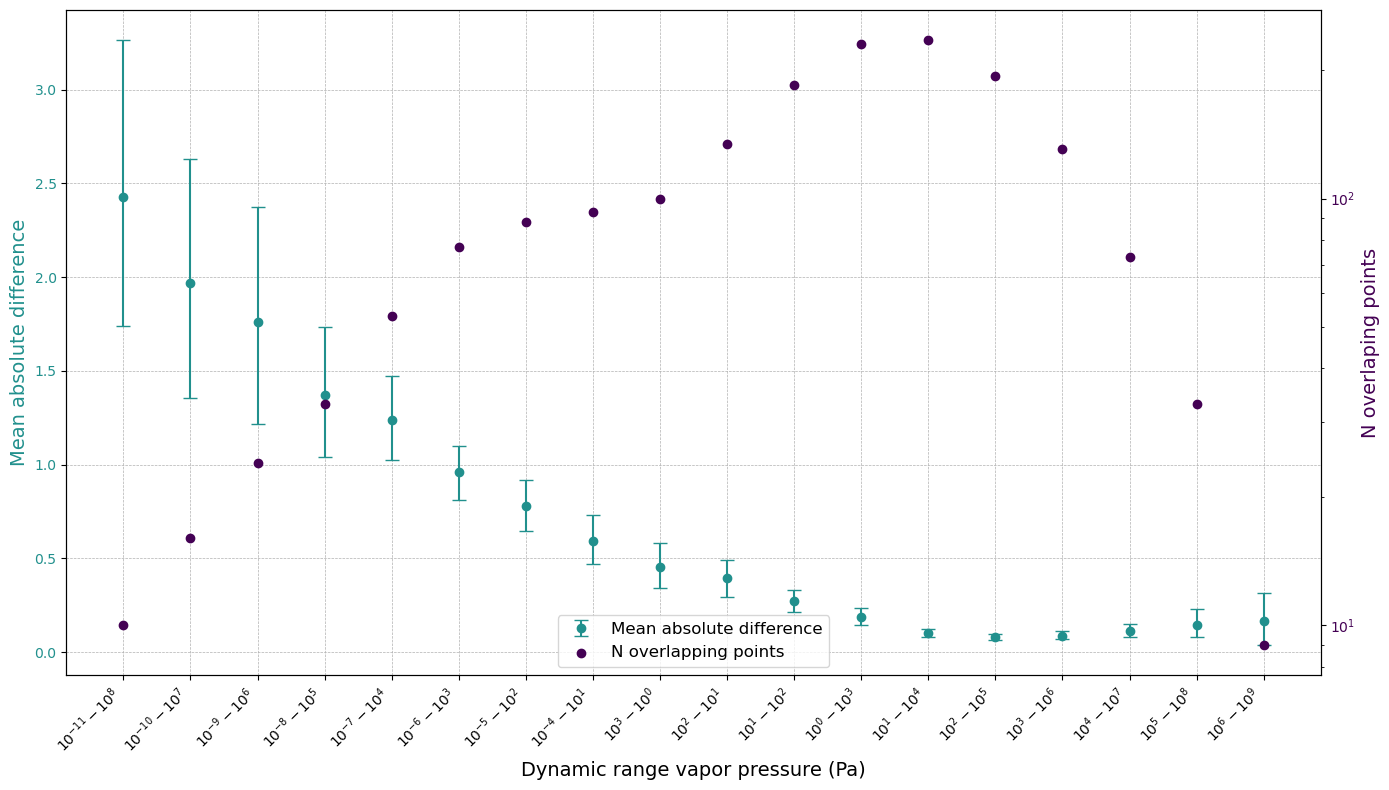

/tmp/ipykernel_1787826/1741557395.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
/tmp/ipykernel_1787826/1741557395.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
/tmp/ipykernel_1787826/1741557395.py:73: SettingWithCopyWarning: 
A value is trying to be 

[(-11, 8), (-10, 7), (-9, 6), (-8, 5), (-7, 4), (-6, 3), (-5, 2), (-4, 1), (3, 0), (2, 1), (1, 2), (0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8), (6, 9)]


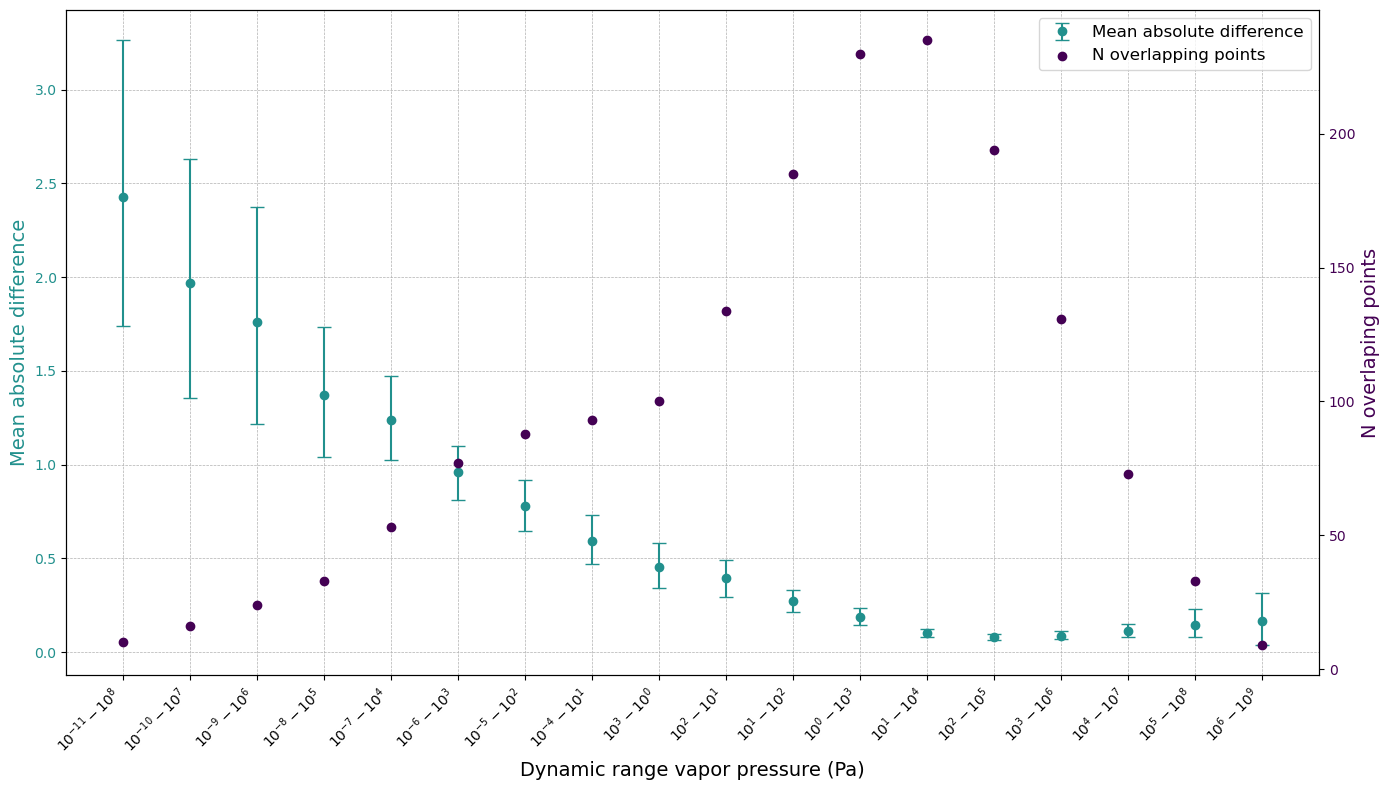

In [185]:
# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(14, 8))
bootstrap_df_mae = bootstrap_df[['Log Range', 'MAE','N']]
bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
bootstrap_df_mae = bootstrap_df_mae.dropna()
log_ranges = bootstrap_df_mae['Log Range']
lb = bootstrap_df_mae['Mean'] - bootstrap_df_mae['Lower']
ub = bootstrap_df_mae['Upper'] - bootstrap_df_mae['Mean']
# long_ranges_new = [(-int(i.split('-')[1]), int(i.split('-')[3])) for i in log_ranges if len(i.split('-')[0]) == 1 else (int(i.split('-')[0]), int(i.split('-')[1]))]
long_ranges_new = []
for l in log_ranges:
    if len(l.split('-')) == 4:
        long_ranges_new.append((-int(l.split('-')[1]), int(l.split('-')[3])))
    elif len(l.split('-')) == 3:
        long_ranges_new.append((int(l.split('-')[1]), int(l.split('-')[2])))
    else:
        long_ranges_new.append((int(l.split('-')[0]), int(l.split('-')[1])))
long_ranges_lower = [l[0] for l in long_ranges_new]
log_ranges_upper = [l[1] for l in long_ranges_new]
xtick_labels = [f'$10^{{{lower}}} - 10^{{{upper}}}$' for lower, upper in zip(long_ranges_lower, log_ranges_upper)]
# Plot Pearson correlation with error bars
ax1.errorbar(
    bootstrap_df_mae['Log Range'], 
    bootstrap_df_mae['Mean'], 
    yerr=[lb, ub], 
    fmt='o', 
    capsize=5, 
    color=pearson_color,
    label='Mean absolute difference'
)
#get log ranges from the log range column

# Customize the first axis
ax1.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax1.set_ylabel('Mean absolute difference', fontsize=14, color=pearson_color)
ax1.tick_params(axis='y', labelcolor=pearson_color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(visible=True, linestyle='--', linewidth=0.5)

# Customize x-tick labels with scientific notation


ax1.set_xticks(np.arange(len(log_ranges)))
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Create the second axis for N
ax2 = ax1.twinx()
ax2.scatter(bootstrap_df_mae['Log Range'], bootstrap_df_mae['N'], color=n_color, label='N overlapping points')
#set the y-axis to log scale
ax2.set_yscale('log')
# Customize the second axis
ax2.set_ylabel('N overlaping points', fontsize=14, color=n_color)
ax2.tick_params(axis='y', labelcolor=n_color)

# combine legend and put in lower center
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower center', fontsize=12)


# Set a tight layout for better spacing
plt.tight_layout()

#save
plt.savefig('mae_bootstrap_logN.png', dpi=800)

# Display the plot
plt.show()

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(14, 8))
bootstrap_df_mae = bootstrap_df[['Log Range', 'MAE','N']]
bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
bootstrap_df_mae = bootstrap_df_mae.dropna()
log_ranges = bootstrap_df_mae['Log Range']
# long_ranges_new = [(-int(i.split('-')[1]), int(i.split('-')[3])) for i in log_ranges if len(i.split('-')[0]) == 1 else (int(i.split('-')[0]), int(i.split('-')[1]))]
long_ranges_new = []
for l in log_ranges:
    if len(l.split('-')) == 4:
        long_ranges_new.append((-int(l.split('-')[1]), int(l.split('-')[3])))
    elif len(l.split('-')) == 3:
        long_ranges_new.append((int(l.split('-')[1]), int(l.split('-')[2])))
    else:
        long_ranges_new.append((int(l.split('-')[0]), int(l.split('-')[1])))
long_ranges = long_ranges_new
print(long_ranges)
# Plot Pearson correlation with error bars
y_val = bootstrap_df_mae['Mean']
lb = y_val - bootstrap_df_mae['Lower']
ub = bootstrap_df_mae['Upper'] - y_val

ax1.errorbar(
    bootstrap_df_mae['Log Range'], 
    bootstrap_df_mae['Mean'], 
    yerr=[lb, ub], 
    fmt='o', 
    capsize=5, 
    color=pearson_color,
    label='Mean absolute difference'
)
#get log ranges from the log range column

# Customize the first axis
ax1.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax1.set_ylabel('Mean absolute difference', fontsize=14, color=pearson_color)
ax1.tick_params(axis='y', labelcolor=pearson_color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(visible=True, linestyle='--', linewidth=0.5)

# Customize x-tick labels with scientific notation
long_ranges_lower = [l[0] for l in long_ranges_new]
log_ranges_upper = [l[1] for l in long_ranges_new]
xtick_labels = [f'$10^{{{lower}}} - 10^{{{upper}}}$' for lower, upper in zip(long_ranges_lower, log_ranges_upper)]

ax1.set_xticks(np.arange(len(log_ranges)))
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Create the second axis for N
ax2 = ax1.twinx()
ax2.scatter(bootstrap_df_mae['Log Range'], bootstrap_df_mae['N'], color=n_color, label='N overlapping points')
# Customize the second axis
ax2.set_ylabel('N overlaping points', fontsize=14, color=n_color)
ax2.tick_params(axis='y', labelcolor=n_color)

# combine legend and put in lower center
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='lower center', fontsize=12)
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=12)


# Set a tight layout for better spacing
plt.tight_layout()

#save
plt.savefig('mae_bootstrap_N.png', dpi=800)

# Display the plot
plt.show()


/tmp/ipykernel_1787826/1657312580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
/tmp/ipykernel_1787826/1657312580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
/tmp/ipykernel_1787826/1657312580.py:4: SettingWithCopyWarning: 
A value is trying to be set

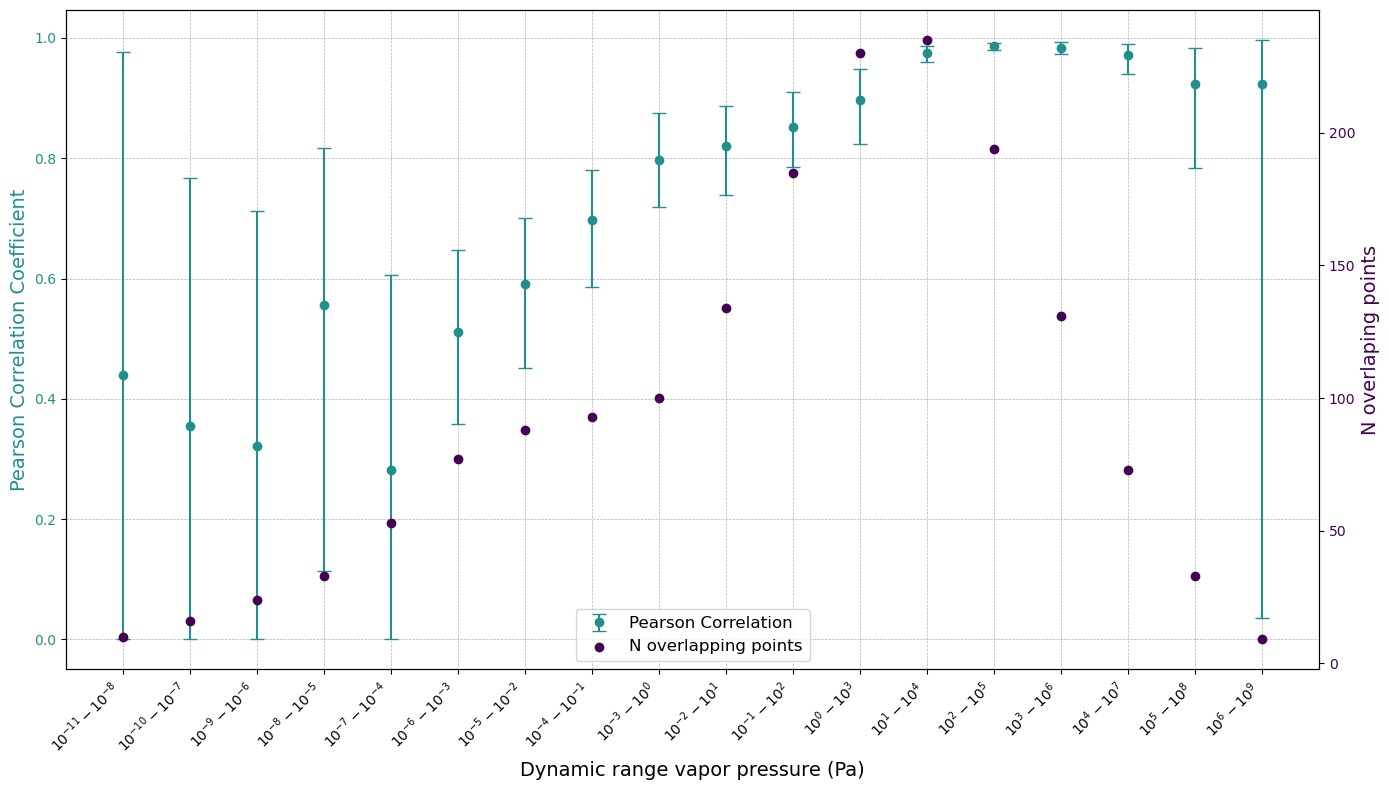

In [196]:

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(14, 8))
bootstrap_df_mae = bootstrap_df[['Log Range', 'MAE','N']]
bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
bootstrap_df_mae = bootstrap_df_mae.dropna()
log_ranges = bootstrap_df_mae['Log Range']
# long_ranges_new = [(-int(i.split('-')[1]), int(i.split('-')[3])) for i in log_ranges if len(i.split('-')[0]) == 1 else (int(i.split('-')[0]), int(i.split('-')[1]))]
long_ranges_new = []
for l in log_ranges:
    if len(l.split('-')) == 4:
        long_ranges_new.append((-int(l.split('-')[1]), -int(l.split('-')[3])))
    elif len(l.split('-')) == 3:
        long_ranges_new.append((-int(l.split('-')[1]), int(l.split('-')[2])))
    else:
        long_ranges_new.append((int(l.split('-')[0]), int(l.split('-')[1])))
long_ranges = long_ranges_new

#also do pearson
bootstrap_df_pearson = bootstrap_df[['Log Range', 'Pearson r','N']]
bootstrap_df_pearson[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_pearson['Pearson r'].tolist(), index=bootstrap_df_pearson.index)
bootstrap_df_pearson = bootstrap_df_pearson.dropna()
lb = bootstrap_df_pearson['Mean'] - bootstrap_df_pearson['Lower']
ub = bootstrap_df_pearson['Upper'] - bootstrap_df_pearson['Mean']

ax1.errorbar(
    bootstrap_df_pearson['Log Range'],
    bootstrap_df_pearson['Mean'],
    yerr=[lb, ub],
    fmt='o',
    capsize=5,
    color=pearson_color,
    label='Pearson Correlation'
)

# Customize the first axis
ax1.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=14, color=pearson_color)
ax1.tick_params(axis='y', labelcolor=pearson_color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(visible=True, linestyle='--', linewidth=0.5)

# Customize x-tick labels with scientific notation
long_ranges_lower = [l[0] for l in long_ranges_new]
log_ranges_upper = [l[1] for l in long_ranges_new]
xtick_labels = [f'$10^{{{lower}}} - 10^{{{upper}}}$' for lower, upper in zip(long_ranges_lower, log_ranges_upper)]

ax1.set_xticks(np.arange(len(log_ranges)))
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Create the second axis for N
ax2 = ax1.twinx()
ax2.scatter(bootstrap_df_mae['Log Range'], bootstrap_df_mae['N'], color=n_color, label='N overlapping points')
# Customize the second axis
ax2.set_ylabel('N overlaping points', fontsize=14, color=n_color)
ax2.tick_params(axis='y', labelcolor=n_color)

# combine legend and put in lower center
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower center', fontsize=12)

# Set a tight layout for better spacing
plt.tight_layout()

#save
plt.savefig('Pearson_bootstrap_N.png', dpi=800)

# Display the plot
plt.show()


/tmp/ipykernel_1787826/3551657317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
/tmp/ipykernel_1787826/3551657317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
/tmp/ipykernel_1787826/3551657317.py:4: SettingWithCopyWarning: 
A value is trying to be set

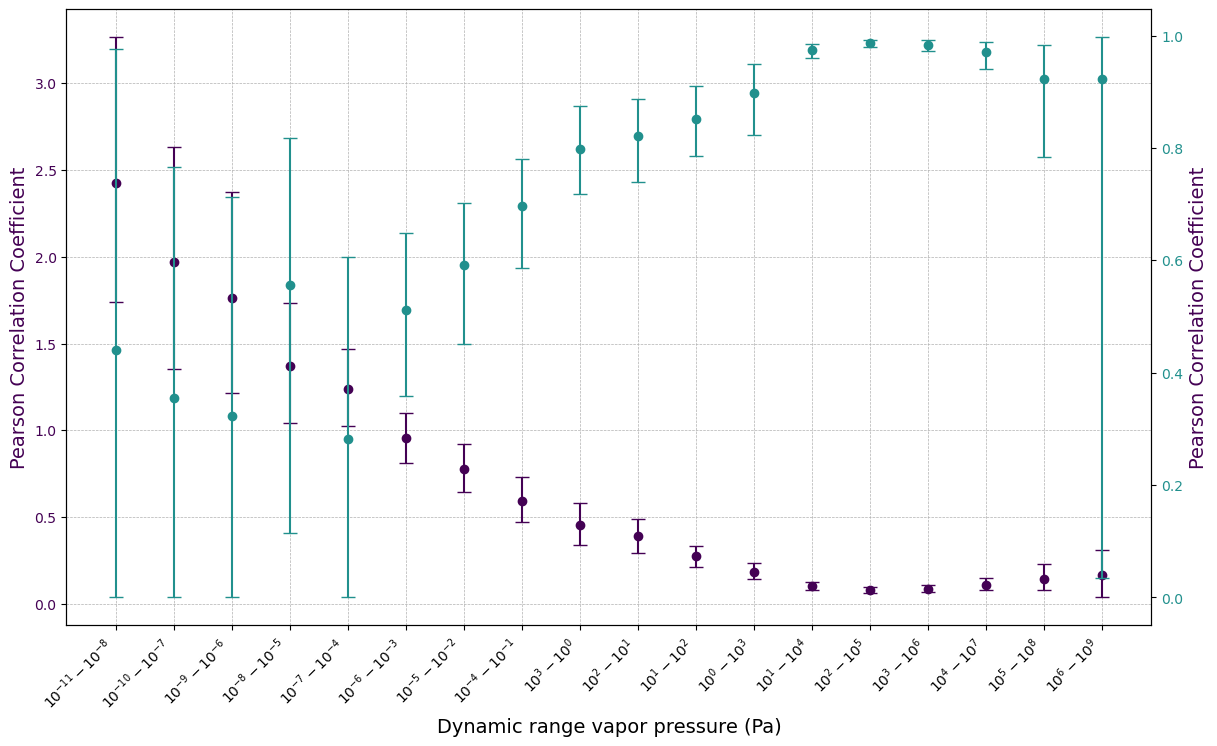

In [194]:

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(14, 8))
bootstrap_df_mae = bootstrap_df[['Log Range', 'MAE','N']]
bootstrap_df_mae[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_mae['MAE'].tolist(), index=bootstrap_df_mae.index)
bootstrap_df_mae = bootstrap_df_mae.dropna()
log_ranges = bootstrap_df_mae['Log Range']
# long_ranges_new = [(-int(i.split('-')[1]), int(i.split('-')[3])) for i in log_ranges if len(i.split('-')[0]) == 1 else (int(i.split('-')[0]), int(i.split('-')[1]))]
long_ranges_new = []
for l in log_ranges:
    if len(l.split('-')) == 4:
        long_ranges_new.append((-int(l.split('-')[1]), -int(l.split('-')[3])))
    elif len(l.split('-')) == 3:
        long_ranges_new.append((int(l.split('-')[1]), int(l.split('-')[2])))
    else:
        long_ranges_new.append((int(l.split('-')[0]), int(l.split('-')[1])))
long_ranges = long_ranges_new

lb = bootstrap_df_mae['Mean'] - bootstrap_df_mae['Lower']
ub = bootstrap_df_mae['Upper'] - bootstrap_df_mae['Mean']

ax1.errorbar(
    bootstrap_df_mae['Log Range'],
    bootstrap_df_mae['Mean'],
    yerr=[lb, ub],
    fmt='o',
    capsize=5,
    color=n_color,
    label='Mean absolute difference'
)

# Customize the first axis
ax1.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=14, color=n_color)
ax1.tick_params(axis='y', labelcolor=n_color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(visible=True, linestyle='--', linewidth=0.5)

# Customize x-tick labels with scientific notation
long_ranges_lower = [l[0] for l in long_ranges_new]
log_ranges_upper = [l[1] for l in long_ranges_new]
xtick_labels = [f'$10^{{{lower}}} - 10^{{{upper}}}$' for lower, upper in zip(long_ranges_lower, log_ranges_upper)]

ax1.set_xticks(np.arange(len(log_ranges)))
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Create the second axis for N
ax2 = ax1.twinx()

#also do pearson
bootstrap_df_pearson = bootstrap_df[['Log Range', 'Pearson r','N']]
bootstrap_df_pearson[['Lower', 'Upper', 'Mean']] = pd.DataFrame(bootstrap_df_pearson['Pearson r'].tolist(), index=bootstrap_df_pearson.index)
bootstrap_df_pearson = bootstrap_df_pearson.dropna()
lb = bootstrap_df_pearson['Mean'] - bootstrap_df_pearson['Lower']
ub = bootstrap_df_pearson['Upper'] - bootstrap_df_pearson['Mean']

ax2.errorbar(
    bootstrap_df_pearson['Log Range'],
    bootstrap_df_pearson['Mean'],
    yerr=[lb, ub],
    fmt='o',
    capsize=5,
    color=pearson_color,
    label='Pearson Correlation'
)

ax2.set_ylabel('Pearson Correlation Coefficient', fontsize=14, color=n_color)
ax2.tick_params(axis='y', labelcolor=pearson_color)




,Log Range,MAE,N,Lower,Upper,Mean
0,-11--8,"(1.6895505434369336, 1.0, 2.4245185334116806)",10,1.689551,1.000000,2.424519
1,-10--7,"(1.405144277779057, 1.0, 1.968242408794225)",16,1.405144,1.000000,1.968242
2,-9--6,"(1.2341088577242874, 1.0, 1.7605234160130419)",24,1.234109,1.000000,1.760523
3,-8--5,"(1.0450035175656336, 1.0, 1.369250175905176)",33,1.045004,1.000000,1.369250
4,-7--4,"(1.0130034210580379, 1.0, 1.2363908352028712)",53,1.013003,1.000000,1.236391
5,-6--3,"(0.8123372919581331, 1.0, 0.9588724373177502)",77,0.812337,1.000000,0.958872
6,-5--2,"(0.6467121901816998, 0.9103482671636169, 0.779...",88,0.646712,0.910348,0.779548
7,-4--1,"(0.4670594185705636, 0.7232752214209522, 0.594...",93,0.467059,0.723275,0.594363
8,-3-0,"(0.35267364924512223, 0.5732357964235845, 0.45...",100,0.352674,0.573236,0.455467
9,-2-1,"(0.3036255579891253, 0.48272242426008855, 0.39...",134,0.303626,0.482722,0.393997


In [146]:
log_ranges = bootstrap_df_mae['Log Range']
long_ranges_new = []
for l in log_ranges:
    if len(l.split('-')) == 4:
        long_ranges_new.append((-int(l.split('-')[1]), int(l.split('-')[3])))
    elif len(l.split('-')) == 3:
        long_ranges_new.append((int(l.split('-')[1]), int(l.split('-')[2])))
    else:
        long_ranges_new.append((int(l.split('-')[0]), int(l.split('-')[1])))
long_ranges_lower = [l[0] for l in long_ranges_new]
log_ranges_upper = [l[1] for l in long_ranges_new]
xtick_labels = [f'$10^{{{lower}}} - 10^{{{upper}}}$' for lower, upper in zip(long_ranges_lower, log_ranges_upper)]
xtick_labels

['$10^{-11} - 10^{8}$',
 '$10^{-10} - 10^{7}$',
 '$10^{-9} - 10^{6}$',
 '$10^{-8} - 10^{5}$',
 '$10^{-7} - 10^{4}$',
 '$10^{-6} - 10^{3}$',
 '$10^{-5} - 10^{2}$',
 '$10^{-4} - 10^{1}$',
 '$10^{3} - 10^{0}$',
 '$10^{2} - 10^{1}$',
 '$10^{1} - 10^{2}$',
 '$10^{0} - 10^{3}$',
 '$10^{1} - 10^{4}$',
 '$10^{2} - 10^{5}$',
 '$10^{3} - 10^{6}$',
 '$10^{4} - 10^{7}$',
 '$10^{5} - 10^{8}$',
 '$10^{6} - 10^{9}$']

In [138]:
xtick_labels = [f'$10^{{{l[0]}}} - 10^{{{l[1]}}}$' for l in log_ranges]
xtick_labels

['$10^{-} - 10^{1}$',
 '$10^{-} - 10^{1}$',
 '$10^{-} - 10^{9}$',
 '$10^{-} - 10^{8}$',
 '$10^{-} - 10^{7}$',
 '$10^{-} - 10^{6}$',
 '$10^{-} - 10^{5}$',
 '$10^{-} - 10^{4}$',
 '$10^{-} - 10^{3}$',
 '$10^{-} - 10^{2}$',
 '$10^{-} - 10^{1}$',
 '$10^{0} - 10^{-}$',
 '$10^{1} - 10^{-}$',
 '$10^{2} - 10^{-}$',
 '$10^{3} - 10^{-}$',
 '$10^{4} - 10^{-}$',
 '$10^{5} - 10^{-}$',
 '$10^{6} - 10^{-}$']

In [141]:
[(l[0],l[1]) for l in log_ranges]

[('-', '1'),
 ('-', '1'),
 ('-', '9'),
 ('-', '8'),
 ('-', '7'),
 ('-', '6'),
 ('-', '5'),
 ('-', '4'),
 ('-', '3'),
 ('-', '2'),
 ('-', '1'),
 ('0', '-'),
 ('1', '-'),
 ('2', '-'),
 ('3', '-'),
 ('4', '-'),
 ('5', '-'),
 ('6', '-')]

In [134]:
for logmin,logmax in log_ranges:
    print(logmin,logmax)

ValueError: too many values to unpack (expected 2)

In [112]:
log_ranges = bootstrap_df_mae['Log Range'].values
log_ranges

array(['-11--8', '-10--7', '-9--6', '-8--5', '-7--4', '-6--3', '-5--2',
       '-4--1', '-3-0', '-2-1', '-1-2', '0-3', '1-4', '2-5', '3-6', '4-7',
       '5-8', '6-9'], dtype=object)

In [136]:
log_ranges[1].split('-')
# long_ranges_new = [(-int(i.split('-')[1]), int(i.split('-')[3])) for i in log_ranges if len(i.split('-')[0]) == 1 else (int(i.split('-')[0]), int(i.split('-')[1]))]
long_ranges_new = []
for l in log_ranges:
    if len(l.split('-')) == 4:
        long_ranges_new.append((-int(l.split('-')[1]), int(l.split('-')[3])))
    elif len(l.split('-')) == 3:
        long_ranges_new.append((int(l.split('-')[1]), int(l.split('-')[2])))
    else:
        long_ranges_new.append((int(l.split('-')[0]), int(l.split('-')[1])))
long_ranges_new

[(-11, 8),
 (-10, 7),
 (-9, 6),
 (-8, 5),
 (-7, 4),
 (-6, 3),
 (-5, 2),
 (-4, 1),
 (3, 0),
 (2, 1),
 (1, 2),
 (0, 3),
 (1, 4),
 (2, 5),
 (3, 6),
 (4, 7),
 (5, 8),
 (6, 9)]

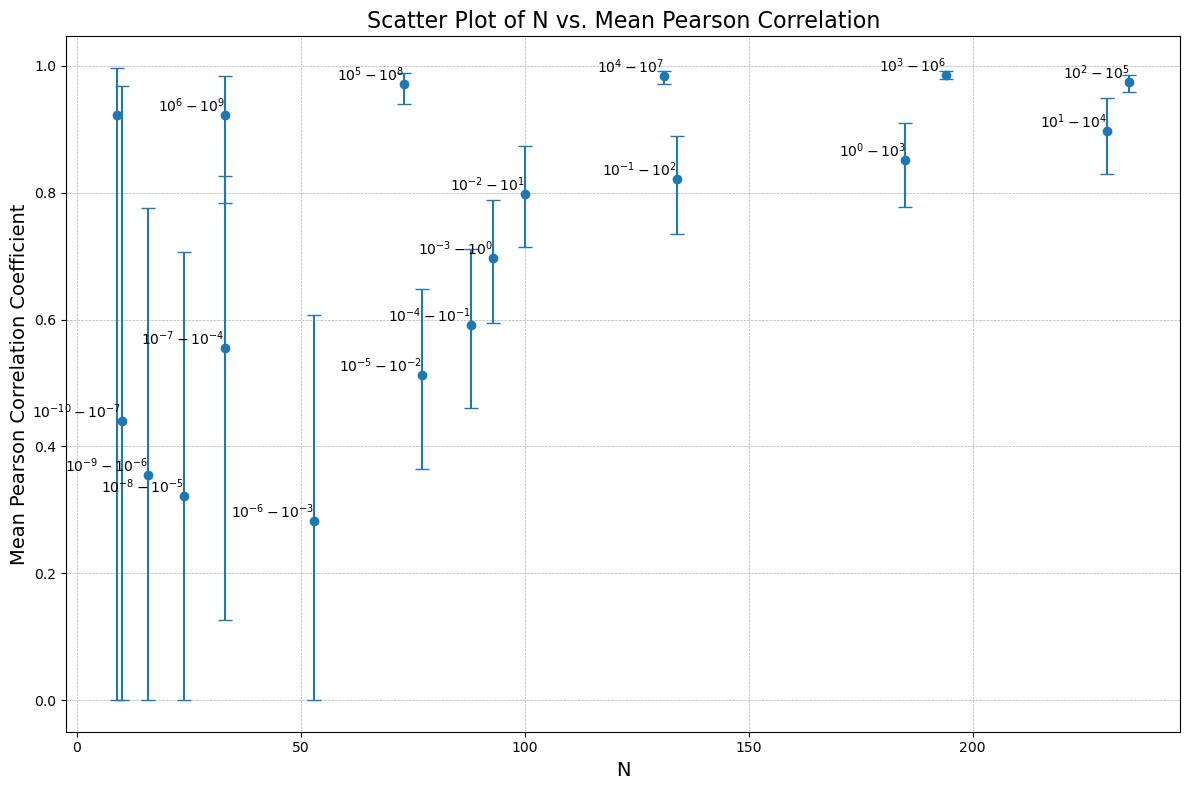

In [86]:
import matplotlib.pyplot as plt

# Extract data from bootstrap_df_pearson
x = bootstrap_df_pearson['N']
y = bootstrap_df_pearson['Mean']
yerr = [lb, ub]
ranges = [f'{log_min}-{log_max}' for log_min, log_max in log_ranges]
#makes ranges prettier
ranges = [f'$10^{{{log_min}}} - 10^{{{log_max}}}$' for log_min, log_max in log_ranges]

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.errorbar(
    x, 
    y, 
    yerr=yerr, 
    fmt='o', 
    capsize=5, 
    color='#1f77b4', 
    label='Pearson Mean with 90% CI'
)

# Add labels for each point
for i, range_label in enumerate(ranges):
    plt.text(
        x[i], 
        y[i], 
        range_label, 
        fontsize=10, 
        ha='right', 
        va='bottom', 
        color='black'
    )

# Customize plot aesthetics
plt.xlabel('N', fontsize=14)
plt.ylabel('Mean Pearson Correlation Coefficient', fontsize=14)
plt.title('Scatter Plot of N vs. Mean Pearson Correlation', fontsize=16)
plt.grid(visible=True, linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()


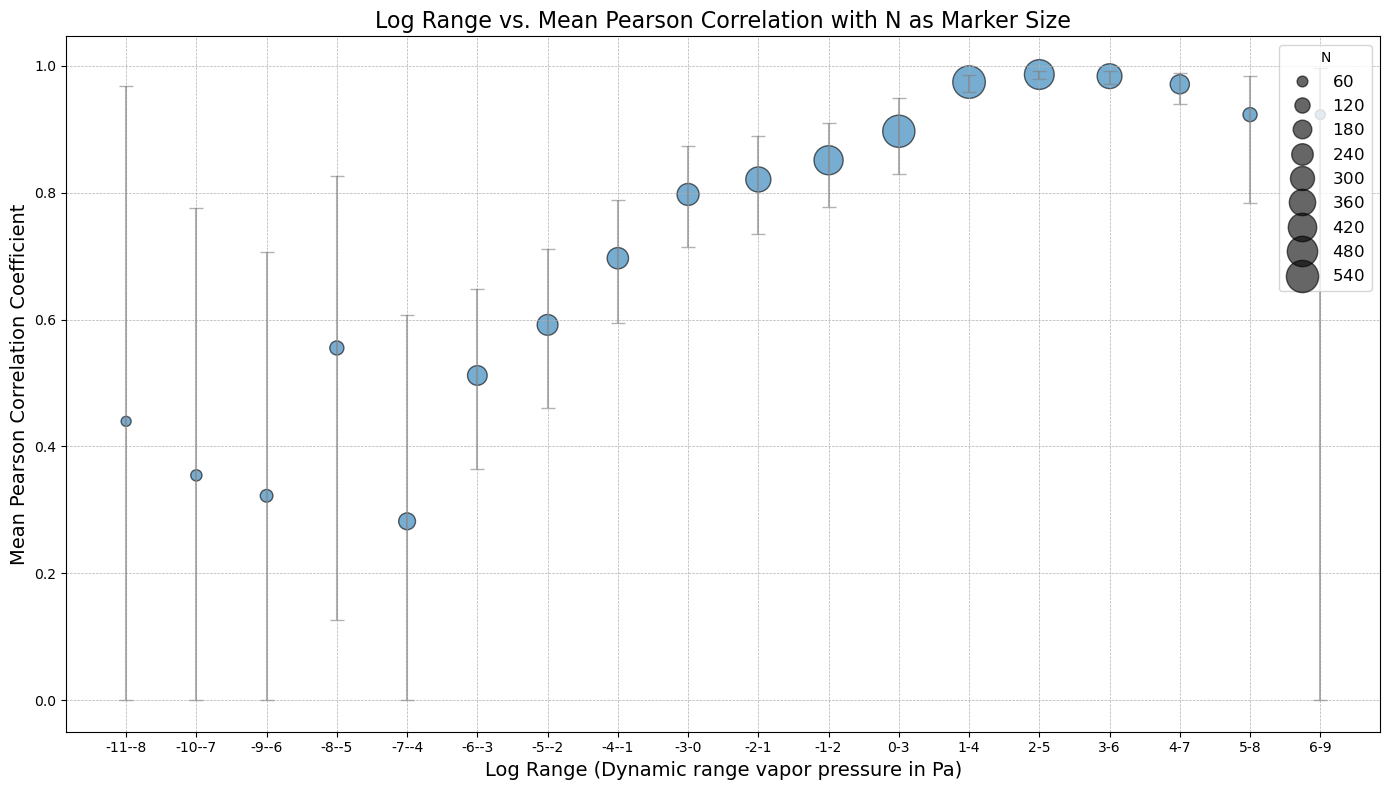

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data from bootstrap_df_pearson
x = bootstrap_df_pearson['Log Range']
y = bootstrap_df_pearson['Mean']
yerr = [lb, ub]
sizes = bootstrap_df_pearson['N']  # Use N to set the size of the markers
ranges = [f'{log_min}-{log_max}' for log_min, log_max in log_ranges]

# Normalize sizes for better visualization
normalized_sizes = (sizes - sizes.min()) / (sizes.max() - sizes.min()) * 500 + 50  # Scale sizes between 50 and 500

# Create the scatter plot
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    x,
    y,
    s=normalized_sizes,
    c='#1f77b4',
    alpha=0.6,
    edgecolor='black',
    label='Pearson Mean'
)

# Plot error bars
plt.errorbar(
    x,
    y,
    yerr=yerr,
    fmt='none',
    ecolor='gray',
    capsize=5,
    alpha=0.6
)

# # Add labels for each point to show the log range
# for i, range_label in enumerate(ranges):
#     plt.text(
#         x[i],
#         y[i],
#         range_label,
#         fontsize=10,
#         ha='center',
#         va='bottom',
#         color='black'
#     )

# Customize plot aesthetics
plt.xlabel('Log Range (Dynamic range vapor pressure in Pa)', fontsize=14)
plt.ylabel('Mean Pearson Correlation Coefficient', fontsize=14)
plt.title('Log Range vs. Mean Pearson Correlation with N as Marker Size', fontsize=16)
plt.grid(visible=True, linestyle='--', linewidth=0.5)

# Add a legend for marker size
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.legend(handles, labels, title='N', loc='upper right', fontsize=12)

# Set tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
